In [ ]:
########################################################################################################################
####-------| NOTE 1.A. IMPORTS LIBRARIES | XXX -----------------------------------------------------####################
########################################################################################################################


"""Train CIFAR100 with PyTorch."""

# Python 2/3 compatibility
# from __future__ import print_function


# Standard libraries
import sys
import os
import argparse
from tqdm import tqdm
import math
import random
import numpy as np


# PyTorch and related modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# torchvision for datasets and transforms
import torchvision
import torchvision.transforms as transforms
import torch_optimizer as torch_opt  # Use 'torch_opt' for torch_optimizer
from timm.scheduler import CosineLRScheduler 
from torch.optim.lr_scheduler import OneCycleLR





# ✅ Define currect working directory to ensure on right directory
VGG16_PATH = r"C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay"
if os.getcwd() != VGG16_PATH:
    os.chdir(VGG16_PATH)
print(f"✅ Current working directory: {os.getcwd()}")

# ✅ Define absolute paths
PROJECT_PATH = VGG16_PATH
MODELS_PATH = os.path.join(VGG16_PATH, "models")
ACTIVATION_PATH = os.path.join(VGG16_PATH, "activation")
# PAU_PATH = os.path.join(VGG16_PATH, "pau")

# ✅ Ensure necessary paths are in sys.path
for path in [PROJECT_PATH, MODELS_PATH, ACTIVATION_PATH]:
    if path not in sys.path:
        sys.path.append(path)

# ✅ Print updated sys.path for debugging
print("✅ sys.path updated:")
for path in sys.path:
    print("   📂", path)

# ✅ Import FFTGate (Check if the module exists)
try:
    from activation.FFTGate import FFTGate  # type: ignore
    print("✅ FFTGate imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ Import failed: {e}")
    print(f"🔍 Check that 'Activation4.py' exists inside: {ACTIVATION_PATH}")

# ✅ Test if FFTGate is callable
try:
    activation_test = FFTGate()
    print("✅ FFTGate instance created successfully!")
except Exception as e:
    print(f"❌ Error while initializing FFTGate: {e}")

# ✅ Now import FFTGate_VGG (Ensure module exists inside models/)
try:
    from models.FFTGate_VGG import FFTGate_VGG  # type: ignore
    print("✅ FFTGate_VGG imported successfully!")
except ModuleNotFoundError as e:
    print(f"❌ FFTGate_VGG import failed: {e}")
    print(f"🔍 Check that 'FFTGate_VGG.py' exists inside: {MODELS_PATH}")






########################################################################################################################
####-------| NOTE 1.B. SEEDING FOR REPRODUCIBILITY | XXX -------------------------------------------####################
########################################################################################################################

def set_seed_torch(seed):
    torch.manual_seed(seed)                          



def set_seed_main(seed):
    random.seed(seed)                                ## Python's random module
    np.random.seed(seed)                             ## NumPy's random module
    torch.cuda.manual_seed(seed)                     ## PyTorch's random module for CUDA
    torch.cuda.manual_seed_all(seed)                 ## Seed for all CUDA devices
    torch.backends.cudnn.deterministic = True        ## Ensure deterministic behavior for CuDNN
    torch.backends.cudnn.benchmark = False           ## Disable CuDNN's autotuning for reproducibility



# Variable seed for DataLoader shuffling
set_seed_torch(1)   

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  







# (Optional) Import Optimizers - Uncomment as needed
# from Opt import opt
# from diffGrad import diffGrad
# from diffRGrad import diffRGrad, SdiffRGrad, BetaDiffRGrad, Beta12DiffRGrad, BetaDFCDiffRGrad
# from RADAM import Radam, BetaRadam
# from BetaAdam import BetaAdam, BetaAdam1, BetaAdam2, BetaAdam3, BetaAdam4, BetaAdam5, BetaAdam6, BetaAdam7, BetaAdam4A
# from AdamRM import AdamRM, AdamRM1, AdamRM2, AdamRM3, AdamRM4, AdamRM5
# from sadam import sadam
# from SdiffGrad import SdiffGrad
# from SRADAM import SRADAM






########################################################################################################################
####-------| NOTE 2. DEFINE MODEL Lr | XXX ---------------------------------------------------------####################
########################################################################################################################

# Main Execution (Placeholder)
if __name__ == "__main__":
    print("CIFAR100 Training Script Initialized...")
    # Add your training pipeline here


import argparse
import os

# Argument parser to get user inputs
parser = argparse.ArgumentParser(description='PyTorch CIFAR100 Training')
parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
parser.add_argument('--resume', '-r', action='store_true', help='resume from checkpoint')

args, unknown = parser.parse_known_args()  # Avoids Jupyter argument issues
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Ensure lr is correctly parsed
lr = args.lr  # Get learning rate from argparse
lr_str = str(lr).replace('.', '_')  # Convert to string and replace '.' for filenames

# Debugging prints
print(f"Using device: {device}")
print(f"Parsed learning rate: {lr} (type: {type(lr)})")
print(f"Formatted learning rate for filenames: {lr_str}")

# Initialize training variables
best_acc = 0  # Best test accuracy
start_epoch = 0  # Start from epoch 0 or last checkpoint epoch






########################################################################################################################
####-------| NOTE 3. LOAD DATASET | XXX ------------------------------------------------------------####################
########################################################################################################################

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

bs = 64 #set batch size
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=bs, shuffle=False, num_workers=0)
#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')





# ✅ Length of train and test datasets
len_train = len(trainset)
len_test = len(testset)
print(f"Length of training dataset: {len_train}")
print(f"Length of testing dataset: {len_test}")

# ✅ Print number of classes
num_classes_Print = len(trainset.classes)
print(f"Number of classes in CIFAR-100: {num_classes_Print}")





########################################################################################################################
####-------| NOTE 4. DYNAMIC REGULARIZATION| XXX ---------------------------------------------------####################
########################################################################################################################

def apply_dynamic_regularization(inputs, feature_activations, epoch,
                                  prev_params, layer_index_map, batch_idx):


    global activation_layers  # ✅ Reference already-collected layers

    # ✅ Print gamma1 stats early in training for monitoring
    if batch_idx == 0 and epoch <= 4:
        print(f"\n🚨 ENTERED apply_dynamic_regularization | Epoch={epoch} | Batch={batch_idx}", flush=True)

        # 🧠 Print gamma1 details
        all_layer_info = []
        for idx, layer in enumerate(activation_layers):
            param = getattr(layer, "gamma1")
            all_layer_info.append(f"Layer {idx}: ID={id(param)} | Mean={param.mean().item():.5f}")
        print("🧠 GAMMA1 INFO:", " | ".join(all_layer_info), flush=True)

    # ✅ Initialize gamma1 regularization accumulator
    gamma1_reg = 0.0

    # ✅ Compute batch std and define regularization strength
    batch_std = torch.std(inputs) + 1e-6
    regularization_strength = 0.05 if epoch < 40 else (0.01 if epoch < 60 else 0.005)

    # ✅ Track layers where noise is injected (informative)
    noisy_layers = []
    for idx, layer in enumerate(activation_layers):
        if idx not in layer_index_map:
            continue

        prev_layer_params = prev_params[layer_index_map[idx]]
        param_name = "gamma1"
        param = getattr(layer, param_name)
        prev_param = prev_layer_params[param_name]

        # ✅ Target based on input stats
        target = compute_target(param_name, batch_std)

        # ✅ Adaptive Target Regularization
        gamma1_reg += regularization_strength * (param - target).pow(2).mean() * 1.2

        # ✅ Adaptive Cohesion Regularization
        cohesion = (param - prev_param).pow(2)
        gamma1_reg += 0.005 * cohesion.mean()

        # ✅ Adaptive Noise Regularization
        epoch_AddNoise = 50
        if epoch > epoch_AddNoise:
            param_variation = torch.abs(param - prev_param).mean()
            if param_variation < 0.015:
                noise = (0.001 + 0.0004 * batch_std.item()) * torch.randn_like(param)
                penalty = (param - (prev_param + noise)).pow(2).sum()
                gamma1_reg += 0.00015 * penalty
                noisy_layers.append(f"{idx} (Δ={param_variation.item():.5f})") # Collect index and variation

    # ✅ Print noise injection summary
    if batch_idx == 0 and epoch <= (epoch_AddNoise + 4) and noisy_layers:
        print(f"🔥 Stable Noise Injected | Epoch {epoch} | Batch {batch_idx} | Layers: " + ", ".join(noisy_layers), flush=True)
    mags = feature_activations.abs().mean(dim=(0, 2, 3))
    m = mags / mags.sum()
    gamma1_reg += 0.005 * (-(m * torch.log(m + 1e-6)).sum())

    return gamma1_reg


def compute_target(param_name, batch_std):
    if param_name == "gamma1":
        return 2.0 + 0.2 * batch_std.item()  

    raise ValueError(f"Unknown param {param_name}")





########################################################################################################################
####-------| NOTE 5. INITIALIZE MODEL | XXX --------------------------------------------------------####################
########################################################################################################################

# Model
print('==> Building model..')
#net = Elliott_VGG('VGG16'); net1 = 'Elliott_VGG16'
#net = GELU_MobileNet(); net1 = 'GELU_MobileNet'
#net = GELU_SENet18(); net1 = 'GELU_SENet18'
#net = PDELU_ResNet50(); net1 = 'PDELU_ResNet50'
# net = Sigmoid_GoogLeNet(); net1 = 'Sigmoid_GoogLeNet'
#net = GELU_DenseNet121(); net1 = 'GELU_DenseNet121'
# net = ReLU_VGG('VGG16'); net1 = 'ReLU_VGG16'
net = FFTGate_VGG('VGG16'); net1 = 'FFTGate_VGG16'


net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9); optimizer1 = 'SGDM5'
#optimizer = optim.Adagrad(net.parameters()); optimizer1 = 'AdaGrad'
#optimizer = optim.Adadelta(net.parameters()); optimizer1 = 'AdaDelta'
#optimizer = optim.RMSprop(net.parameters()); optimizer1 = 'RMSprop'
optimizer = optim.Adam(net.parameters(), lr=args.lr); optimizer1 = 'Adam'
#optimizer = optim.Adam(net.parameters(), lr=args.lr, amsgrad=True); optimizer1 = 'amsgrad'
#optimizer = diffGrad(net.parameters(), lr=args.lr); optimizer1 = 'diffGrad'
#optimizer = Radam(net.parameters(), lr=args.lr); optimizer1 = 'Radam'







########################################################################################################################
####-------| NOTE 6. INITIALIZE ACTIVATION PARAMETERS, OPTIMIZERS & SCHEDULERS | XXX ---------------####################
########################################################################################################################

import torch
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# ✅ Step 1: Collect Activation Parameters from ALL Layers (Ensure Compatibility with DataParallel)
if isinstance(net, torch.nn.DataParallel):
    features = net.module.features
else:
    features = net.features





# ✅ Step 2: Recursively search for FFTGate layers
activation_params = []
activation_layers = []

for layer in features:
    if isinstance(layer, FFTGate):  
        activation_layers.append(layer)
        activation_params.append(layer.gamma1)  # ✅ Only gamma1 is trainable





# ✅ Step 3: Define Unfreeze Epoch
unfreeze_activation_epoch = 1  # ✅ Change this value if needed
# unfreeze_activation_epoch = 10  # ✅ Delay unfreezing until epoch 10


# ✅ Define the warm-up epoch value
# WARMUP_ACTIVATION_EPOCHS = 5  # The number of epochs for warm-up
WARMUP_ACTIVATION_EPOCHS = 0  # The number of epochs for warm-up


# ✅ Step 4: Initially Freeze Activation Parameters
for param in activation_params:
    param.requires_grad = False  # 🚫 Keep frozen before the unfreeze epoch




# ✅ Step 4: Initialize Activation Optimizers (Using AdamW for Better Weight Decay)
activation_optimizers = {
    "gamma1": torch.optim.AdamW(activation_params, lr=0.0015, weight_decay=1e-6)  # 🔺 Reduce LR from 0.005 → 0.0025
}




# ✅ Step 5: Initialize Activation Schedulers with Warm Restarts (Per Parameter Type)
activation_schedulers = {
    "gamma1": CosineAnnealingWarmRestarts(
        activation_optimizers["gamma1"],
        T_0=10,      # Shorter cycle to explore aggressively
        T_mult=2,    # Increase cycle length gradually
        eta_min=5e-5  # ✅ recommended safer modification
    )
}





# ✅ Step 6: Print collected activation layers and parameters
if activation_layers and activation_params:
    print(f"✅ Found {len(activation_layers)} FFTGate layers.")
    print(f"✅ Collected {len(activation_params)} trainable activation parameters.")
    
    for idx, layer in enumerate(activation_layers):
        print(f"   🔹 Layer {idx}: {layer}")

elif activation_layers and not activation_params:
    print(f"⚠ Warning: Found {len(activation_layers)} FFTGate layers, but no trainable parameters were collected.")

elif activation_params and not activation_layers:
    print(f"⚠ Warning: Collected {len(activation_params)} activation parameters, but no FFTGate layers were recorded.")

else:
    print("⚠ Warning: No FFTGate layers or activation parameters found! Skipping activation optimizer.")
    activation_optimizers = None


########################################################################################################################
####-------| NOTE 7. INITIALIZE MAIN OPTIMIZER SCHEDULER | XXX -------------------------------------####################
########################################################################################################################

# ✅ Step 6: Define MultiStepLR for Main Optimizer
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)

main_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1, last_epoch=-1)






########################################################################################################################
####-------| NOTE 8. MODEL CHECK POINT | XXX -------------------------------------------------------####################
########################################################################################################################

import os
import torch

# Ensure directories exist
if not os.path.exists('checkpoint'):
    os.makedirs('checkpoint')

if not os.path.exists('Results'):
    os.makedirs('Results')

# Construct checkpoint path
checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr}_{net1}_{optimizer1}.t7'

# Resume checkpoint only if file exists
if args.resume:
    print('==> Resuming from checkpoint..')
    
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
        print(f"Checkpoint loaded: {checkpoint_path}")
    else:
        print(f"Error: Checkpoint file not found: {checkpoint_path}")





########################################################################################################################
####-------| NOTE 9. DEFINE TRAIN LOOP | XXX -------------------------------------------------------####################
########################################################################################################################

# ✅ Used for naming files 
decay_mode = "Exponential"  # Options: "exp" or "linear"

# Training

def train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler , WARMUP_ACTIVATION_EPOCHS):
    global train_loss_history, best_train_acc, prev_params, recent_test_acc, gamma1_history, activation_layers, test_acc_history, train_acc_history, decay_mode  # 🟢🟢🟢

    if epoch == 0:
        train_loss_history = []
        train_acc_history = []
        best_train_acc = 0.0
        recent_test_acc = 0.0
        gamma1_history = {}         # ✅ Initialize history
        test_acc_history = []       # ✅ test accuracy history



    prev_params = {}
    layer_index_map = {idx: idx for idx in range(len(activation_layers))}  

    # ✅ Cache previous gamma1 values from activation layers
    for idx, layer in enumerate(activation_layers):
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }



    net.train()
    train_loss = 0
    correct = 0
    total = 0
    train_accuracy = 0.0

    # ✅ Initialize log history
    log_history = []



    # ✅ Define path to store Training log
    save_paths = {
       
        "log_history": f"C:\\Users\\emeka\\Research\\ModelCUDA\\Big_Data_Journal\\Comparison\\Code\\Paper\\github2\\AblationExperiments\\NonMonotonicDecay-ExponentialDecay\\Results\\FFTGate\\FFTGate_training_logs.txt"  # ✅ Training log_history 
    }




    # ✅ Step 1: Unfreeze Activation Parameters (Only Once Per Epoch)
    if epoch == unfreeze_activation_epoch:
        print("\n🔓 Unfreezing Activation Function Parameters 🔓")
        for layer in net.module.features if isinstance(net, torch.nn.DataParallel) else net.features:
            if isinstance(layer, FFTGate):   
                layer.gamma1.requires_grad = True  # ✅ Only gamma1 is trainable
        print("✅ Activation Parameters Unfrozen! 🚀")





    # ✅ Step 2: Gradual Warm-up for Activation Learning Rates (AFTER Unfreezing)
    warmup_start = unfreeze_activation_epoch  # 🔹 Start warm-up when unfreezing happens
    warmup_end = unfreeze_activation_epoch + WARMUP_ACTIVATION_EPOCHS  # 🔹 End warm-up period

    # ✅ Adjust learning rates **only** during the warm-up phase
    if warmup_start <= epoch < warmup_end:
        warmup_factor = (epoch - warmup_start + 1) / WARMUP_ACTIVATION_EPOCHS  

        for name, act_scheduler in activation_schedulers.items():
            for param_group in act_scheduler.optimizer.param_groups:
                if "initial_lr" not in param_group:
                    param_group["initial_lr"] = param_group["lr"]  # 🔹 Store initial LR
                param_group["lr"] = param_group["initial_lr"] * warmup_factor  # 🔹 Scale LR

        # ✅ Debugging output to track warm-up process
        print(f"🔥 Warm-up Epoch {epoch}: Scaling LR by {warmup_factor:.3f}")
        for name, act_scheduler in activation_schedulers.items():
            print(f"  🔹 {name} LR: {act_scheduler.optimizer.param_groups[0]['lr']:.6f}")






    activation_history = []  # 🔴 Initialize empty history at start of epoch (outside batch loop)



    # ✅ Training Loop
    with tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch}") as progress:
        for batch_idx, (inputs, targets) in progress:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()


            # zero_grad activation parameter
            for opt in activation_optimizers.values():
                opt.zero_grad()


            # ✅ Forward Pass
            outputs = net(inputs, epoch=epoch, train_accuracy=train_accuracy, targets=targets)
            loss = criterion(outputs, targets)

            
            feature_activations = features(inputs)  # Feature activations


            # ✅ Collect Activation History | ✅ Per-layer mean activations
            batch_means = [layer.saved_output.mean().item() for layer in activation_layers]
            activation_history.extend(batch_means)

            # ✅ Apply Decay strategy to history for each activation layer
            with torch.no_grad():
                for layer in activation_layers:
                    if isinstance(layer, FFTGate):
                        layer.decay_spectral_history(epoch, num_epochs)




            # ✅ Compute Training Accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            train_accuracy = 100. * correct / total if total > 0 else 0.0  # Compute training accuracy





            # ✅ Call Regularization Function for the Activation Parameter
            if epoch > 0:
                gamma1_reg = apply_dynamic_regularization(
                    inputs, feature_activations, epoch,
                    prev_params, layer_index_map, batch_idx
                )
                loss += gamma1_reg




            # ✅ Backward pass
            loss.backward()



            # ✅ 🎯 Adaptive Gradient Clipping of gamma1  
            for layer in features:
                if isinstance(layer, FFTGate):  # ✅ Ensure layer has gamma1 before clipping
                    torch.nn.utils.clip_grad_norm_([layer.gamma1], max_norm=0.7)
                        



            # ✅ Apply Optimizer Step for Model Parameters
            optimizer.step()

            # ✅ Apply Optimizer Steps for Activation Parameters (Only if Unfrozen)
            if epoch >= unfreeze_activation_epoch:
                for opt in activation_optimizers.values():
                    opt.step()


            # ✅ Accumulate loss
            train_loss += loss.item()



            # ✅ Clamping of gamma1 (Applied AFTER Optimizer Step)
            with torch.no_grad():
                for layer in activation_layers:
                    layer.gamma1.clamp_(0.1, 6.0)  




            # ✅ Update progress bar
            progress.set_postfix(Train_loss=round(train_loss / (batch_idx + 1), 3),
                                 Train_acc=train_accuracy)  



    # ✅ Step the main optimizer scheduler (ONLY for model parameters)
    main_scheduler.step()

    # ✅ Step the activation parameter schedulers (ONLY for activation parameters) | Epoch-wise stepping
    if epoch >= unfreeze_activation_epoch:
        for name, act_scheduler in activation_schedulers.items():  
            act_scheduler.step()  




    # ✅ ONLY update prev_params here AFTER all updates | ✅ Update prev_params AFTER training epoch
    for idx, layer in enumerate(activation_layers):      
        prev_params[idx] = {
            "gamma1": layer.gamma1.clone().detach()
        }




    # ✅ Logging Activation Parameters & Gradients
    last_batch_grads = {"Gamma1 Grad": []}
    current_params = {"Gamma1": []}

    for layer in features:
        if isinstance(layer, FFTGate):  
            # ✅ Convert gradients to scalar floats and format to 5 decimal places (removes device='cuda:0' and tensor(...))
            last_batch_grads["Gamma1 Grad"].append(f"{layer.gamma1.grad.item():.5f}" if layer.gamma1.grad is not None else "None")

            # ✅ Collect current parameter values (already scalar), formatted to 5 decimal places
            current_params["Gamma1"].append(f"{layer.gamma1.item():.5f}")

    # ✅ Build log message (showing params and gradients for ALL layers)
    log_msg = (
        f"Epoch {epoch}: M_Optimizer LR => {optimizer.param_groups[0]['lr']:.5f} | "
        f"Gamma1 LR => {activation_optimizers['gamma1'].param_groups[0]['lr']:.5f} | "
        f"Gamma1: {current_params['Gamma1']} | "
        f"Gamma1 Grad: {last_batch_grads['Gamma1 Grad']}"
    )

    log_history.append(log_msg)
    print(log_msg)  # ✅ Prints only once per epoch




    # ✅ Initialize log file at the beginning of training (Clear old logs)
    if epoch == 0:  # ✅ Only clear at the start of training
        with open(save_paths["log_history"], "w", encoding="utf-8") as log_file:
            log_file.write("")  # ✅ Clears previous logs

    # ✅ Save logs once per epoch (Append new logs)
    if log_history:
        with open(save_paths["log_history"], "a", encoding="utf-8") as log_file:
            log_file.write("\n".join(log_history) + "\n")         # ✅ Ensure each entry is on a new line
        print(f"📜 Logs saved to {save_paths['log_history']}!")  # ✅ Only prints once per epoch
    else:
        print("⚠ No logs to save!")




    # ✅ Compute final training accuracy for the epoch
    final_train_loss = train_loss / len(trainloader)
    final_train_acc = 100. * correct / total

    # ✅ Append to history
    train_loss_history.append(final_train_loss)

    # Append per-epoch training accuracy
    train_acc_history.append(final_train_acc)




    # ✅ Save training results (without affecting best accuracy tracking)
    train_results_path = f'./Results/CIFAR100_Train_{decay_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'

    # ✅ Clear the log file at the start of training (Epoch 0)
    if epoch == 0 and os.path.exists(train_results_path):
        with open(train_results_path, 'w') as f:
            f.write("")  # ✅ Clears previous logs only once

    # ✅ Append new training results for each epoch
    with open(train_results_path, 'a') as f:
        f.write(f"Epoch {epoch} | Train Loss: {final_train_loss:.3f} | Train Acc: {final_train_acc:.3f}%\n")

    if final_train_acc > best_train_acc:
        best_train_acc = final_train_acc  # ✅ Update best training accuracy
        print(f"🏆 New Best Training Accuracy: {best_train_acc:.3f}% (Updated)")

    # ✅ Append the best training accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):  # Only log once at the final epoch
        with open(train_results_path, 'a') as f:
            f.write(f"\n🏆 Best Training Accuracy: {best_train_acc:.3f}%\n")  

    # ✅ Print both Final and Best Training Accuracy
    print(f"📊 Train Accuracy: {final_train_acc:.3f}% | 🏆 Best Train Accuracy: {best_train_acc:.3f}%")




    print(f"📜 Training logs saved to {train_results_path}!")
    print(f"🏆 Best Training Accuracy: {best_train_acc:.3f}% (Updated)")



    if epoch % 10 == 0:
        print(f"📏 Sizes → ActivationHist: {len(activation_history)} | TestAccHist: {len(test_acc_history)} | TrainLossHist: {len(train_loss_history)}")



    # return final_train_loss, final_train_acc, feature_activations













########################################################################################################################
####-------| NOTE 10. DEFINE TEST LOOP | XXX -------------------------------------------------------####################
########################################################################################################################


import os
import torch
from tqdm import tqdm

def test(epoch, save_results=True):
    """
    Evaluates the model on the test set and optionally saves the results.
    
    Args:
    - epoch (int): The current epoch number.
    - save_results (bool): Whether to save results to a file.

    Returns:
    - acc (float): Test accuracy percentage.
    """
    global best_acc, val_accuracy, decay_mode  
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    # ✅ Ensure activation function parameters are clamped before evaluation
    with torch.no_grad():
        with tqdm(enumerate(testloader), total=len(testloader), desc=f"Testing Epoch {epoch}") as progress:
            for batch_idx, (inputs, targets) in progress:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # ✅ Pass validation accuracy to activation function
                val_accuracy = 100. * correct / total if total > 0 else 0


                # ✅ Update progress bar with loss & accuracy
                progress.set_postfix(Test_loss=round(test_loss / (batch_idx + 1), 3),
                                     Test_acc=round(val_accuracy, 3))



    # ✅ Compute final test accuracy
    final_test_loss = test_loss / len(testloader)
    final_test_acc = 100. * correct / total






    # ✅ Ensure "Results" folder exists (just like training logs)
    results_dir = os.path.join(PROJECT_PATH, "Results")
    os.makedirs(results_dir, exist_ok=True)

    # ✅ Define log file path for test results
    test_results_path = os.path.join(results_dir, f'CIFAR100_Test_{decay_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt')

    # ✅ Initialize log file at the beginning of training (clear old logs)
    if epoch == 0:
        with open(test_results_path, 'w', encoding="utf-8") as f:
            f.write("")  # ✅ Clears previous logs

    # ✅ Append new test results for each epoch (same style as training)
    with open(test_results_path, 'a', encoding="utf-8") as f:
        f.write(f"Epoch {epoch} | Test Loss: {final_test_loss:.3f} | Test Acc: {final_test_acc:.3f}%\n")







    # ✅ Save checkpoint if accuracy improves (does NOT interfere with logging)
    if final_test_acc > best_acc:
        print('🏆 Saving best model...')
        state = {
            'net': net.state_dict(),
            'acc': final_test_acc,  # ✅ Ensures the best test accuracy is saved in checkpoint
            'epoch': epoch,
        }




        # Ensure checkpoint directory exists
        checkpoint_dir = "checkpoint"
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)


        # ✅ Format learning rate properly before saving filename
        lr_str = str(lr).replace('.', '_')
        checkpoint_path = f'./checkpoint/CIFAR100_B{bs}_LR{lr_str}_{net1}_{optimizer1}.t7'
        torch.save(state, checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")


        best_acc = final_test_acc  # ✅ Update best accuracy




    # ✅ Append the best test accuracy **only once at the end of training**
    if epoch == (num_epochs - 1):
        with open(test_results_path, 'a', encoding="utf-8") as f:
            f.write(f"\n🏆 Best Test Accuracy: {best_acc:.3f}%\n")



    # ✅ Print both Final and Best Test Accuracy (always executed)
    print(f"📊 Test Accuracy: {final_test_acc:.3f}% | 🏆 Best Test Accuracy: {best_acc:.3f}%")
    print(f"📜 Test logs saved to {test_results_path}!")


    global recent_test_acc
    recent_test_acc = final_test_acc  # Capture latest test accuracy for next train() call | Store latest test accuracy

    test_acc_history.append(final_test_acc)

    return final_test_acc  # ✅ Return the test accuracy

✅ Current working directory: C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay
✅ sys.path updated:
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\python310.zip
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\DLLs
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env
   📂 
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\win32\lib
   📂 c:\Users\emeka\anaconda3\envs\pytorch_env\lib\site-packages\Pythonwin
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay
   📂 C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\models
   📂 C:\Users\emeka\Res

In [ ]:
########################################################################################################################
####-------| NOTE 11. TRAIN MODEL WITH SHEDULAR | XXX ----------------------------------------------####################
########################################################################################################################



# ✅ Set Seed for Reproducibility BEFORE training starts

# Variable seed for DataLoader shuffling
set_seed_torch(1)  

# Variable main seed (model, CUDA, etc.)
set_seed_main(2)  

# ✅ Training Loop
num_epochs = 100 # Example: Set the total number of epochs
for epoch in range(start_epoch, num_epochs):   # Runs training for 100 epochs

    train(epoch, optimizer, activation_optimizers, activation_schedulers, unfreeze_activation_epoch, main_scheduler, WARMUP_ACTIVATION_EPOCHS) # ✅ Pass required arguments

    test(epoch)  # ✅ Test the model
    tqdm.write("")  # ✅ Clear leftover progress bar from test()


print("Best Test Accuracy: ", best_acc)

Epoch 0: 100%|██████████| 782/782 [00:25<00:00, 30.56it/s, Train_acc=3.35, Train_loss=4.36]


Epoch 0: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000', '1.50000'] | Gamma1 Grad: ['None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 3.350% (Updated)
📊 Train Accuracy: 3.350% | 🏆 Best Train Accuracy: 3.350%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 3.350% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 0 | TrainLossHist: 1


Testing Epoch 0: 100%|██████████| 157/157 [00:01<00:00, 86.20it/s, Test_acc=5.41, Test_loss=4.04]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 5.410% | 🏆 Best Test Accuracy: 5.410%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!


🔓 Unfreezing Activation Function Parameters 🔓
✅ Activation Parameters Unfrozen! 🚀


Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=1 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=3221649784512 | Mean=1.50000 | Layer 1: ID=3221649931808 | Mean=1.50000 | Layer 2: ID=3221618873808 | Mean=1.50000 | Layer 3: ID=3221618873008 | Mean=1.50000 | Layer 4: ID=3221618872048 | Mean=1.50000 | Layer 5: ID=3221618870928 | Mean=1.50000 | Layer 6: ID=3221618870448 | Mean=1.50000 | Layer 7: ID=3222318891712 | Mean=1.50000 | Layer 8: ID=3222318892592 | Mean=1.50000 | Layer 9: ID=3222318893472 | Mean=1.50000 | Layer 10: ID=3222318894272 | Mean=1.50000 | Layer 11: ID=3222318895152 | Mean=1.50000 | Layer 12: ID=3222318896032 | Mean=1.50000


Epoch 1: 100%|██████████| 782/782 [00:34<00:00, 22.97it/s, Train_acc=6.75, Train_loss=4.09]


Epoch 1: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.22781', '2.23194', '2.23034', '2.22686', '2.22855', '2.22689', '2.22713', '2.22528', '2.22704', '2.22714', '2.22265', '2.21825', '2.21159'] | Gamma1 Grad: ['0.00214', '-0.00183', '-0.00286', '-0.00159', '-0.00979', '-0.01015', '-0.00498', '-0.00686', '-0.01170', '-0.01135', '-0.00357', '-0.02437', '-0.00659']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 6.746% (Updated)
📊 Train Accuracy: 6.746% | 🏆 Best Train Accuracy: 6.746%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 6.746% (Updated)


Testing Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 80.68it/s, Test_acc=7.64, Test_loss=3.89]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 7.640% | 🏆 Best Test Accuracy: 7.640%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=2 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=3221649784512 | Mean=2.22781 | Layer 1: ID=3221649931808 | Mean=2.23194 | Layer 2: ID=3221618873808 | Mean=2.23034 | Layer 3: ID=3221618873008 | Mean=2.22686 | Layer 4: ID=3221618872048 | Mean=2.22855 | Layer 5: ID=3221618870928 | Mean=2.22689 | Layer 6: ID=3221618870448 | Mean=2.22713 | Layer 7: ID=3222318891712 | Mean=2.22528 | Layer 8: ID=3222318892592 | Mean=2.22704 | Layer 9: ID=3222318893472 | Mean=2.22714 | Layer 10: ID=3222318894272 | Mean=2.22265 | Layer 11: ID=3222318895152 | Mean=2.21825 | Layer 12: ID=3222318896032 | Mean=2.21159


Epoch 2: 100%|██████████| 782/782 [00:34<00:00, 22.45it/s, Train_acc=10.3, Train_loss=3.7] 


Epoch 2: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.28495', '2.29992', '2.28982', '2.28479', '2.28348', '2.28275', '2.28155', '2.28322', '2.28172', '2.28178', '2.27952', '2.27889', '2.26284'] | Gamma1 Grad: ['-0.02534', '0.00153', '0.00537', '-0.00349', '-0.00198', '0.00287', '0.00000', '-0.00125', '0.00623', '-0.00278', '-0.00325', '0.02547', '-0.00187']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 10.310% (Updated)
📊 Train Accuracy: 10.310% | 🏆 Best Train Accuracy: 10.310%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 10.310% (Updated)


Testing Epoch 2: 100%|██████████| 157/157 [00:01<00:00, 81.15it/s, Test_acc=12.4, Test_loss=3.54]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 12.390% | 🏆 Best Test Accuracy: 12.390%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=3 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=3221649784512 | Mean=2.28495 | Layer 1: ID=3221649931808 | Mean=2.29992 | Layer 2: ID=3221618873808 | Mean=2.28982 | Layer 3: ID=3221618873008 | Mean=2.28479 | Layer 4: ID=3221618872048 | Mean=2.28348 | Layer 5: ID=3221618870928 | Mean=2.28275 | Layer 6: ID=3221618870448 | Mean=2.28155 | Layer 7: ID=3222318891712 | Mean=2.28322 | Layer 8: ID=3222318892592 | Mean=2.28172 | Layer 9: ID=3222318893472 | Mean=2.28178 | Layer 10: ID=3222318894272 | Mean=2.27952 | Layer 11: ID=3222318895152 | Mean=2.27889 | Layer 12: ID=3222318896032 | Mean=2.26284


Epoch 3: 100%|██████████| 782/782 [00:34<00:00, 22.40it/s, Train_acc=14.9, Train_loss=3.4] 


Epoch 3: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.30631', '2.30927', '2.30376', '2.29201', '2.29277', '2.29178', '2.29116', '2.28787', '2.29035', '2.28992', '2.28731', '2.28535', '2.27190'] | Gamma1 Grad: ['0.00481', '0.01261', '0.00507', '0.00230', '0.00955', '-0.00182', '-0.00476', '0.00619', '-0.00535', '-0.01281', '-0.01213', '-0.04024', '-0.02490']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 14.864% (Updated)
📊 Train Accuracy: 14.864% | 🏆 Best Train Accuracy: 14.864%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 14.864% (Updated)


Testing Epoch 3: 100%|██████████| 157/157 [00:01<00:00, 84.73it/s, Test_acc=17.4, Test_loss=3.24]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 17.360% | 🏆 Best Test Accuracy: 17.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]


🚨 ENTERED apply_dynamic_regularization | Epoch=4 | Batch=0
🧠 GAMMA1 INFO: Layer 0: ID=3221649784512 | Mean=2.30631 | Layer 1: ID=3221649931808 | Mean=2.30927 | Layer 2: ID=3221618873808 | Mean=2.30376 | Layer 3: ID=3221618873008 | Mean=2.29201 | Layer 4: ID=3221618872048 | Mean=2.29277 | Layer 5: ID=3221618870928 | Mean=2.29178 | Layer 6: ID=3221618870448 | Mean=2.29116 | Layer 7: ID=3222318891712 | Mean=2.28787 | Layer 8: ID=3222318892592 | Mean=2.29035 | Layer 9: ID=3222318893472 | Mean=2.28992 | Layer 10: ID=3222318894272 | Mean=2.28731 | Layer 11: ID=3222318895152 | Mean=2.28535 | Layer 12: ID=3222318896032 | Mean=2.27190


Epoch 4: 100%|██████████| 782/782 [00:34<00:00, 22.65it/s, Train_acc=19.4, Train_loss=3.15]


Epoch 4: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.30224', '2.31555', '2.30293', '2.29850', '2.29402', '2.29978', '2.29413', '2.29269', '2.29427', '2.29638', '2.29254', '2.28212', '2.28239'] | Gamma1 Grad: ['0.00181', '0.00036', '0.00540', '0.00272', '0.00113', '0.00029', '-0.00641', '-0.00201', '-0.00353', '-0.00813', '-0.00905', '0.01753', '0.00542']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 19.378% (Updated)
📊 Train Accuracy: 19.378% | 🏆 Best Train Accuracy: 19.378%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 19.378% (Updated)


Testing Epoch 4: 100%|██████████| 157/157 [00:01<00:00, 81.23it/s, Test_acc=21.4, Test_loss=3.01]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 21.450% | 🏆 Best Test Accuracy: 21.450%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 5: 100%|██████████| 782/782 [00:34<00:00, 22.85it/s, Train_acc=23.8, Train_loss=2.93]


Epoch 5: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.31415', '2.32279', '2.31610', '2.30188', '2.30212', '2.30470', '2.29551', '2.29570', '2.29787', '2.29307', '2.29076', '2.28335', '2.27907'] | Gamma1 Grad: ['-0.00248', '0.01535', '-0.00592', '-0.01383', '-0.00546', '0.00441', '0.00662', '-0.00304', '-0.00236', '0.00978', '0.00652', '0.01437', '-0.02213']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 23.818% (Updated)
📊 Train Accuracy: 23.818% | 🏆 Best Train Accuracy: 23.818%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 23.818% (Updated)


Testing Epoch 5: 100%|██████████| 157/157 [00:01<00:00, 83.27it/s, Test_acc=27.2, Test_loss=2.73]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 27.250% | 🏆 Best Test Accuracy: 27.250%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 6: 100%|██████████| 782/782 [00:35<00:00, 22.29it/s, Train_acc=28.1, Train_loss=2.73]


Epoch 6: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.32142', '2.31311', '2.30795', '2.28848', '2.30355', '2.30045', '2.29032', '2.29158', '2.28979', '2.28994', '2.29244', '2.28824', '2.29176'] | Gamma1 Grad: ['-0.02193', '-0.01981', '-0.01363', '-0.00726', '-0.00556', '0.00666', '0.00100', '-0.00321', '0.00125', '0.00313', '0.00006', '0.00055', '0.00679']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 28.132% (Updated)
📊 Train Accuracy: 28.132% | 🏆 Best Train Accuracy: 28.132%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 28.132% (Updated)


Testing Epoch 6: 100%|██████████| 157/157 [00:02<00:00, 78.20it/s, Test_acc=28.9, Test_loss=2.64]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 28.930% | 🏆 Best Test Accuracy: 28.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 7: 100%|██████████| 782/782 [00:33<00:00, 23.09it/s, Train_acc=32.1, Train_loss=2.53]


Epoch 7: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.31621', '2.31274', '2.30009', '2.29203', '2.29652', '2.29598', '2.29170', '2.29203', '2.29050', '2.29308', '2.29298', '2.28522', '2.29021'] | Gamma1 Grad: ['0.00524', '0.00827', '0.01702', '-0.00313', '-0.00184', '-0.00375', '0.00343', '-0.00218', '-0.00649', '-0.00805', '0.01119', '-0.03516', '0.11920']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 32.114% (Updated)
📊 Train Accuracy: 32.114% | 🏆 Best Train Accuracy: 32.114%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 32.114% (Updated)


Testing Epoch 7: 100%|██████████| 157/157 [00:01<00:00, 79.68it/s, Test_acc=33.1, Test_loss=2.46]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 33.130% | 🏆 Best Test Accuracy: 33.130%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 8: 100%|██████████| 782/782 [00:34<00:00, 22.84it/s, Train_acc=36, Train_loss=2.36]  


Epoch 8: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.32046', '2.31969', '2.30985', '2.29372', '2.29612', '2.29671', '2.28956', '2.29852', '2.29951', '2.30040', '2.30000', '2.27924', '2.29307'] | Gamma1 Grad: ['0.01051', '0.00013', '-0.00165', '0.02623', '0.00533', '0.00015', '0.00153', '-0.00222', '0.00916', '0.00219', '0.00728', '0.00428', '0.05219']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 36.042% (Updated)
📊 Train Accuracy: 36.042% | 🏆 Best Train Accuracy: 36.042%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 36.042% (Updated)


Testing Epoch 8: 100%|██████████| 157/157 [00:01<00:00, 86.36it/s, Test_acc=38.6, Test_loss=2.21]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 38.600% | 🏆 Best Test Accuracy: 38.600%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 9: 100%|██████████| 782/782 [00:34<00:00, 22.57it/s, Train_acc=39.5, Train_loss=2.21]


Epoch 9: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.32142', '2.31966', '2.31572', '2.29480', '2.30418', '2.29750', '2.28799', '2.30048', '2.29739', '2.29852', '2.29850', '2.27756', '2.29923'] | Gamma1 Grad: ['-0.00198', '-0.02950', '0.00399', '0.00633', '-0.00367', '0.00147', '0.00400', '0.00035', '0.00794', '0.00250', '-0.00556', '0.00774', '0.02601']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 39.496% (Updated)
📊 Train Accuracy: 39.496% | 🏆 Best Train Accuracy: 39.496%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 39.496% (Updated)


Testing Epoch 9: 100%|██████████| 157/157 [00:01<00:00, 80.10it/s, Test_acc=42.5, Test_loss=2.06]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 42.480% | 🏆 Best Test Accuracy: 42.480%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 10: 100%|██████████| 782/782 [00:34<00:00, 22.77it/s, Train_acc=43, Train_loss=2.07]  


Epoch 10: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.31928', '2.32180', '2.31086', '2.29954', '2.29881', '2.30259', '2.28996', '2.29500', '2.29570', '2.29574', '2.29473', '2.28736', '2.29742'] | Gamma1 Grad: ['-0.00746', '0.01075', '-0.01073', '-0.00966', '-0.00376', '0.00669', '0.01324', '0.00472', '0.00775', '-0.00177', '0.00503', '-0.01044', '0.02581']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 43.028% (Updated)
📊 Train Accuracy: 43.028% | 🏆 Best Train Accuracy: 43.028%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 43.028% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 10 | TrainLossHist: 11


Testing Epoch 10: 100%|██████████| 157/157 [00:01<00:00, 85.29it/s, Test_acc=43.1, Test_loss=2.06]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 43.140% | 🏆 Best Test Accuracy: 43.140%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 11: 100%|██████████| 782/782 [00:34<00:00, 22.57it/s, Train_acc=45.5, Train_loss=1.96]


Epoch 11: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.31966', '2.31492', '2.31832', '2.29369', '2.32402', '2.29231', '2.28501', '2.29872', '2.30446', '2.29604', '2.29875', '2.27838', '2.30080'] | Gamma1 Grad: ['-0.02763', '0.01788', '-0.00846', '0.01088', '-0.01332', '-0.01867', '-0.00595', '0.00926', '0.00849', '0.00189', '0.00144', '-0.01179', '0.01114']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 45.530% (Updated)
📊 Train Accuracy: 45.530% | 🏆 Best Train Accuracy: 45.530%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 45.530% (Updated)


Testing Epoch 11: 100%|██████████| 157/157 [00:01<00:00, 84.11it/s, Test_acc=45.7, Test_loss=1.93]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 45.700% | 🏆 Best Test Accuracy: 45.700%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 12: 100%|██████████| 782/782 [00:34<00:00, 22.98it/s, Train_acc=48, Train_loss=1.87]  


Epoch 12: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.31196', '2.31069', '2.31805', '2.28527', '2.29437', '2.30077', '2.28592', '2.29637', '2.28881', '2.27865', '2.27965', '2.28884', '2.30791'] | Gamma1 Grad: ['-0.00530', '0.02613', '-0.00464', '-0.00337', '-0.00816', '-0.02771', '-0.00243', '-0.01235', '-0.00783', '-0.00635', '-0.00084', '-0.01586', '0.08617']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 47.998% (Updated)
📊 Train Accuracy: 47.998% | 🏆 Best Train Accuracy: 47.998%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 47.998% (Updated)


Testing Epoch 12: 100%|██████████| 157/157 [00:01<00:00, 83.91it/s, Test_acc=48.7, Test_loss=1.83]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 48.680% | 🏆 Best Test Accuracy: 48.680%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 13: 100%|██████████| 782/782 [00:34<00:00, 22.84it/s, Train_acc=50.1, Train_loss=1.78]


Epoch 13: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['2.31734', '2.31753', '2.31352', '2.31238', '2.30023', '2.30412', '2.29641', '2.31442', '2.30533', '2.29892', '2.29191', '2.28383', '2.30074'] | Gamma1 Grad: ['0.02165', '0.01001', '-0.00676', '-0.00343', '-0.01895', '-0.03043', '0.00889', '0.00102', '0.00181', '0.00008', '-0.00672', '0.01165', '0.07934']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 50.116% (Updated)
📊 Train Accuracy: 50.116% | 🏆 Best Train Accuracy: 50.116%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 50.116% (Updated)


Testing Epoch 13: 100%|██████████| 157/157 [00:01<00:00, 81.02it/s, Test_acc=50.4, Test_loss=1.79]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 50.350% | 🏆 Best Test Accuracy: 50.350%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 14: 100%|██████████| 782/782 [00:34<00:00, 22.78it/s, Train_acc=52.8, Train_loss=1.7] 


Epoch 14: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.29726', '2.32906', '2.32360', '2.29728', '2.30397', '2.30010', '2.28855', '2.30594', '2.29265', '2.29400', '2.29575', '2.27924', '2.30591'] | Gamma1 Grad: ['0.00013', '0.00418', '0.00646', '-0.00422', '-0.01305', '-0.01072', '-0.00814', '-0.00334', '0.00721', '0.00544', '0.00330', '0.00752', '-0.04276']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 52.774% (Updated)
📊 Train Accuracy: 52.774% | 🏆 Best Train Accuracy: 52.774%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 52.774% (Updated)


Testing Epoch 14: 100%|██████████| 157/157 [00:01<00:00, 84.65it/s, Test_acc=51.5, Test_loss=1.71]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 51.490% | 🏆 Best Test Accuracy: 51.490%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 15: 100%|██████████| 782/782 [00:34<00:00, 22.97it/s, Train_acc=54.3, Train_loss=1.63]


Epoch 15: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['2.30380', '2.31925', '2.30620', '2.30685', '2.31286', '2.30606', '2.29835', '2.29733', '2.30664', '2.29651', '2.30844', '2.28967', '2.29497'] | Gamma1 Grad: ['0.03183', '0.04129', '-0.00731', '0.03877', '-0.03744', '0.01009', '-0.00972', '0.02304', '0.01850', '0.03711', '0.03630', '-0.00540', '0.05090']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 54.280% (Updated)
📊 Train Accuracy: 54.280% | 🏆 Best Train Accuracy: 54.280%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 54.280% (Updated)


Testing Epoch 15: 100%|██████████| 157/157 [00:01<00:00, 81.67it/s, Test_acc=51.5, Test_loss=1.75]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 51.520% | 🏆 Best Test Accuracy: 51.520%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 16: 100%|██████████| 782/782 [00:34<00:00, 22.57it/s, Train_acc=55.9, Train_loss=1.56]


Epoch 16: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.29722', '2.30483', '2.31162', '2.29936', '2.30591', '2.31441', '2.28593', '2.30892', '2.30312', '2.29698', '2.29717', '2.28984', '2.30177'] | Gamma1 Grad: ['0.03081', '-0.00621', '0.05532', '0.01109', '-0.01888', '-0.00093', '0.00612', '-0.00126', '-0.00235', '0.00362', '0.00397', '0.02038', '-0.00609']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 55.922% (Updated)
📊 Train Accuracy: 55.922% | 🏆 Best Train Accuracy: 55.922%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 55.922% (Updated)


Testing Epoch 16: 100%|██████████| 157/157 [00:01<00:00, 81.21it/s, Test_acc=52.1, Test_loss=1.74]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 52.130% | 🏆 Best Test Accuracy: 52.130%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 17: 100%|██████████| 782/782 [00:33<00:00, 23.28it/s, Train_acc=57.9, Train_loss=1.5] 


Epoch 17: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['2.32187', '2.32379', '2.30870', '2.30216', '2.29751', '2.30796', '2.28942', '2.30735', '2.29680', '2.28853', '2.28486', '2.29031', '2.32087'] | Gamma1 Grad: ['-0.04454', '0.01188', '0.02123', '0.00308', '-0.01219', '-0.02880', '-0.00980', '0.00096', '0.00555', '0.00322', '-0.00585', '0.00792', '0.01792']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 57.942% (Updated)
📊 Train Accuracy: 57.942% | 🏆 Best Train Accuracy: 57.942%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 57.942% (Updated)


Testing Epoch 17: 100%|██████████| 157/157 [00:01<00:00, 83.72it/s, Test_acc=54.5, Test_loss=1.63]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 54.510% | 🏆 Best Test Accuracy: 54.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 18: 100%|██████████| 782/782 [00:34<00:00, 22.92it/s, Train_acc=59.1, Train_loss=1.44]


Epoch 18: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.31113', '2.31919', '2.29941', '2.30979', '2.31325', '2.31665', '2.30034', '2.30369', '2.30731', '2.30514', '2.29644', '2.28492', '2.31837'] | Gamma1 Grad: ['0.01504', '0.00180', '0.02244', '0.02720', '0.00618', '0.02109', '0.00124', '-0.00162', '-0.01528', '-0.00076', '0.01075', '0.00812', '0.06281']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 59.066% (Updated)
📊 Train Accuracy: 59.066% | 🏆 Best Train Accuracy: 59.066%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 59.066% (Updated)


Testing Epoch 18: 100%|██████████| 157/157 [00:01<00:00, 88.65it/s, Test_acc=55.2, Test_loss=1.61]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 55.220% | 🏆 Best Test Accuracy: 55.220%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 19: 100%|██████████| 782/782 [00:34<00:00, 22.82it/s, Train_acc=60.7, Train_loss=1.38]


Epoch 19: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['2.29846', '2.32449', '2.29952', '2.28616', '2.30113', '2.29709', '2.28581', '2.30473', '2.30122', '2.29096', '2.29493', '2.28777', '2.30565'] | Gamma1 Grad: ['0.00452', '0.02699', '-0.01499', '0.00952', '0.01832', '0.00749', '-0.00690', '-0.00787', '-0.00816', '0.00459', '-0.00179', '-0.01902', '-0.02310']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 60.668% (Updated)
📊 Train Accuracy: 60.668% | 🏆 Best Train Accuracy: 60.668%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 60.668% (Updated)


Testing Epoch 19: 100%|██████████| 157/157 [00:01<00:00, 78.95it/s, Test_acc=56, Test_loss=1.57]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 56.020% | 🏆 Best Test Accuracy: 56.020%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 20: 100%|██████████| 782/782 [00:34<00:00, 22.68it/s, Train_acc=62.3, Train_loss=1.31]


Epoch 20: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.29910', '2.30983', '2.30670', '2.29628', '2.30387', '2.30368', '2.29536', '2.30197', '2.29873', '2.29339', '2.28830', '2.28017', '2.30086'] | Gamma1 Grad: ['0.03703', '-0.00483', '-0.03777', '0.03336', '-0.01157', '-0.02143', '-0.01755', '0.00067', '-0.01410', '0.00264', '-0.00421', '-0.00930', '-0.05142']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 62.322% (Updated)
📊 Train Accuracy: 62.322% | 🏆 Best Train Accuracy: 62.322%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 62.322% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 20 | TrainLossHist: 21


Testing Epoch 20: 100%|██████████| 157/157 [00:01<00:00, 83.57it/s, Test_acc=56.7, Test_loss=1.57]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 56.720% | 🏆 Best Test Accuracy: 56.720%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 21: 100%|██████████| 782/782 [00:34<00:00, 22.69it/s, Train_acc=63.8, Train_loss=1.26]


Epoch 21: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['2.29781', '2.30470', '2.30654', '2.30157', '2.30049', '2.31149', '2.30472', '2.30247', '2.29921', '2.29333', '2.30207', '2.29546', '2.30180'] | Gamma1 Grad: ['0.05176', '0.02713', '0.03274', '0.02215', '0.00412', '0.00089', '-0.02754', '-0.00137', '0.02344', '0.01192', '0.02159', '0.00542', '0.03473']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 63.832% (Updated)
📊 Train Accuracy: 63.832% | 🏆 Best Train Accuracy: 63.832%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 63.832% (Updated)


Testing Epoch 21: 100%|██████████| 157/157 [00:01<00:00, 87.45it/s, Test_acc=57.5, Test_loss=1.53]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 57.510% | 🏆 Best Test Accuracy: 57.510%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 22: 100%|██████████| 782/782 [00:33<00:00, 23.05it/s, Train_acc=64.9, Train_loss=1.22]


Epoch 22: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.30790', '2.30775', '2.29159', '2.29652', '2.29851', '2.30437', '2.30584', '2.30163', '2.29851', '2.29555', '2.29373', '2.29214', '2.30746'] | Gamma1 Grad: ['0.00015', '-0.02006', '0.00101', '-0.00477', '-0.02726', '-0.01711', '-0.01066', '0.00185', '-0.01524', '-0.00688', '-0.00889', '-0.01000', '0.01651']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 64.900% (Updated)
📊 Train Accuracy: 64.900% | 🏆 Best Train Accuracy: 64.900%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 64.900% (Updated)


Testing Epoch 22: 100%|██████████| 157/157 [00:01<00:00, 83.49it/s, Test_acc=58.1, Test_loss=1.52]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 58.080% | 🏆 Best Test Accuracy: 58.080%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 23: 100%|██████████| 782/782 [00:34<00:00, 22.43it/s, Train_acc=66, Train_loss=1.17]  


Epoch 23: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['2.29845', '2.30768', '2.30157', '2.29934', '2.29644', '2.31590', '2.29214', '2.30766', '2.29995', '2.29329', '2.29362', '2.28193', '2.30705'] | Gamma1 Grad: ['-0.03564', '-0.00499', '-0.00340', '-0.01269', '0.00549', '0.01679', '-0.01239', '0.00174', '-0.00093', '-0.00611', '-0.00506', '0.02948', '0.01708']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 65.972% (Updated)
📊 Train Accuracy: 65.972% | 🏆 Best Train Accuracy: 65.972%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 65.972% (Updated)


Testing Epoch 23: 100%|██████████| 157/157 [00:01<00:00, 83.38it/s, Test_acc=58.2, Test_loss=1.52]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 58.230% | 🏆 Best Test Accuracy: 58.230%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 24: 100%|██████████| 782/782 [00:34<00:00, 22.61it/s, Train_acc=67, Train_loss=1.13]  


Epoch 24: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.31022', '2.31449', '2.30324', '2.30607', '2.29971', '2.31038', '2.29110', '2.30284', '2.30382', '2.29931', '2.30365', '2.28902', '2.30252'] | Gamma1 Grad: ['-0.03481', '0.00177', '0.06209', '0.07780', '0.04093', '-0.05740', '0.01015', '-0.00982', '0.00734', '0.00028', '-0.00768', '0.01966', '-0.01109']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 67.018% (Updated)
📊 Train Accuracy: 67.018% | 🏆 Best Train Accuracy: 67.018%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 67.018% (Updated)


Testing Epoch 24: 100%|██████████| 157/157 [00:01<00:00, 82.06it/s, Test_acc=59.2, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 59.250% | 🏆 Best Test Accuracy: 59.250%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 25: 100%|██████████| 782/782 [00:34<00:00, 22.96it/s, Train_acc=68.3, Train_loss=1.08]


Epoch 25: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['2.31770', '2.30086', '2.30377', '2.30963', '2.30241', '2.30343', '2.29435', '2.29874', '2.28458', '2.28644', '2.28971', '2.28714', '2.31118'] | Gamma1 Grad: ['-0.00452', '0.02779', '0.02619', '0.01405', '0.01710', '-0.02609', '0.00080', '0.00706', '-0.00162', '-0.00098', '0.00674', '0.01356', '-0.04145']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 68.258% (Updated)
📊 Train Accuracy: 68.258% | 🏆 Best Train Accuracy: 68.258%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 68.258% (Updated)


Testing Epoch 25: 100%|██████████| 157/157 [00:01<00:00, 83.38it/s, Test_acc=58.9, Test_loss=1.53]


📊 Test Accuracy: 58.860% | 🏆 Best Test Accuracy: 59.250%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 26: 100%|██████████| 782/782 [00:34<00:00, 22.67it/s, Train_acc=69.7, Train_loss=1.04]


Epoch 26: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.30601', '2.31367', '2.30129', '2.29443', '2.30458', '2.30858', '2.30101', '2.31003', '2.29887', '2.29083', '2.28934', '2.28555', '2.29873'] | Gamma1 Grad: ['0.00421', '0.02098', '-0.01823', '-0.05779', '-0.04655', '-0.01248', '0.02474', '-0.00686', '-0.01909', '-0.00686', '-0.02682', '0.01112', '-0.02654']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 69.674% (Updated)
📊 Train Accuracy: 69.674% | 🏆 Best Train Accuracy: 69.674%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 69.674% (Updated)


Testing Epoch 26: 100%|██████████| 157/157 [00:01<00:00, 81.85it/s, Test_acc=60.2, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.250% | 🏆 Best Test Accuracy: 60.250%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 27: 100%|██████████| 782/782 [00:34<00:00, 22.91it/s, Train_acc=71.1, Train_loss=0.989]


Epoch 27: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['2.29767', '2.30704', '2.29488', '2.29474', '2.29882', '2.29773', '2.30306', '2.30961', '2.30155', '2.29771', '2.29456', '2.29709', '2.29927'] | Gamma1 Grad: ['-0.00722', '-0.02544', '-0.04767', '0.00775', '0.05176', '-0.02527', '-0.00471', '0.02316', '-0.00410', '0.00147', '0.00958', '0.00570', '0.08519']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 71.122% (Updated)
📊 Train Accuracy: 71.122% | 🏆 Best Train Accuracy: 71.122%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 71.122% (Updated)


Testing Epoch 27: 100%|██████████| 157/157 [00:01<00:00, 85.35it/s, Test_acc=60.4, Test_loss=1.49]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.350% | 🏆 Best Test Accuracy: 60.350%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 28: 100%|██████████| 782/782 [00:33<00:00, 23.06it/s, Train_acc=71.9, Train_loss=0.957]


Epoch 28: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.29976', '2.31313', '2.30900', '2.29777', '2.30406', '2.30931', '2.30961', '2.30382', '2.29660', '2.29107', '2.30057', '2.28320', '2.30699'] | Gamma1 Grad: ['0.01363', '0.01483', '0.08429', '-0.03017', '-0.02034', '-0.00287', '0.01847', '0.00262', '0.01497', '0.00798', '-0.00528', '0.01161', '0.00951']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 71.928% (Updated)
📊 Train Accuracy: 71.928% | 🏆 Best Train Accuracy: 71.928%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 71.928% (Updated)


Testing Epoch 28: 100%|██████████| 157/157 [00:01<00:00, 86.13it/s, Test_acc=60.5, Test_loss=1.48]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 60.500% | 🏆 Best Test Accuracy: 60.500%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 29: 100%|██████████| 782/782 [00:34<00:00, 22.73it/s, Train_acc=72.8, Train_loss=0.92] 


Epoch 29: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['2.29369', '2.31238', '2.30001', '2.28996', '2.29793', '2.29958', '2.30356', '2.30937', '2.30111', '2.29370', '2.29497', '2.28345', '2.29472'] | Gamma1 Grad: ['0.03228', '-0.03301', '0.03223', '0.00272', '-0.02546', '-0.00248', '0.02307', '-0.00969', '0.00689', '0.00076', '0.00573', '-0.04979', '0.06946']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 72.794% (Updated)
📊 Train Accuracy: 72.794% | 🏆 Best Train Accuracy: 72.794%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 72.794% (Updated)


Testing Epoch 29: 100%|██████████| 157/157 [00:01<00:00, 79.47it/s, Test_acc=61.1, Test_loss=1.48]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.110% | 🏆 Best Test Accuracy: 61.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 30: 100%|██████████| 782/782 [00:35<00:00, 22.24it/s, Train_acc=74, Train_loss=0.888]  


Epoch 30: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.31063', '2.30595', '2.30239', '2.29111', '2.29203', '2.30859', '2.29932', '2.30925', '2.29856', '2.29266', '2.29706', '2.28979', '2.30701'] | Gamma1 Grad: ['-0.00204', '0.00710', '0.03415', '-0.01476', '0.00927', '0.01283', '-0.00278', '0.00646', '-0.00325', '-0.01156', '-0.00354', '0.01063', '-0.01097']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 73.970% (Updated)
📊 Train Accuracy: 73.970% | 🏆 Best Train Accuracy: 73.970%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 73.970% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 30 | TrainLossHist: 31


Testing Epoch 30: 100%|██████████| 157/157 [00:01<00:00, 81.84it/s, Test_acc=60.9, Test_loss=1.48]


📊 Test Accuracy: 60.940% | 🏆 Best Test Accuracy: 61.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 31: 100%|██████████| 782/782 [00:34<00:00, 22.62it/s, Train_acc=75.1, Train_loss=0.843]


Epoch 31: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.30952', '2.30844', '2.30820', '2.30246', '2.30653', '2.31927', '2.30634', '2.31106', '2.28875', '2.29092', '2.28954', '2.29612', '2.30004'] | Gamma1 Grad: ['0.03521', '-0.00844', '0.02507', '-0.04943', '0.03890', '0.00519', '0.00061', '0.02114', '0.00043', '0.00063', '-0.00370', '-0.00162', '-0.04301']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 75.136% (Updated)
📊 Train Accuracy: 75.136% | 🏆 Best Train Accuracy: 75.136%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 75.136% (Updated)


Testing Epoch 31: 100%|██████████| 157/157 [00:01<00:00, 83.27it/s, Test_acc=61.7, Test_loss=1.49]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.700% | 🏆 Best Test Accuracy: 61.700%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 32: 100%|██████████| 782/782 [00:34<00:00, 22.66it/s, Train_acc=76.1, Train_loss=0.813]


Epoch 32: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.30435', '2.31132', '2.30785', '2.28698', '2.28739', '2.31443', '2.29624', '2.31184', '2.29533', '2.28966', '2.28812', '2.28449', '2.29900'] | Gamma1 Grad: ['0.00014', '0.02445', '-0.01852', '-0.03790', '-0.04485', '-0.02342', '0.01051', '0.00452', '-0.00787', '-0.01614', '-0.01631', '0.01136', '-0.01902']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 76.108% (Updated)
📊 Train Accuracy: 76.108% | 🏆 Best Train Accuracy: 76.108%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 76.108% (Updated)


Testing Epoch 32: 100%|██████████| 157/157 [00:01<00:00, 80.72it/s, Test_acc=61.7, Test_loss=1.52]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 61.720% | 🏆 Best Test Accuracy: 61.720%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 33: 100%|██████████| 782/782 [00:34<00:00, 22.56it/s, Train_acc=76.7, Train_loss=0.788]


Epoch 33: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['2.30476', '2.31741', '2.29070', '2.28799', '2.27523', '2.30156', '2.30045', '2.31186', '2.30518', '2.28983', '2.29220', '2.30107', '2.30563'] | Gamma1 Grad: ['0.04424', '0.02099', '-0.03376', '-0.01186', '0.02568', '-0.02680', '0.01675', '-0.01025', '0.00205', '0.00661', '0.00179', '-0.01862', '0.04220']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 76.668% (Updated)
📊 Train Accuracy: 76.668% | 🏆 Best Train Accuracy: 76.668%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 76.668% (Updated)


Testing Epoch 33: 100%|██████████| 157/157 [00:01<00:00, 85.06it/s, Test_acc=62, Test_loss=1.47]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.020% | 🏆 Best Test Accuracy: 62.020%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 34: 100%|██████████| 782/782 [00:34<00:00, 22.84it/s, Train_acc=77.6, Train_loss=0.756]


Epoch 34: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.30758', '2.32514', '2.27961', '2.29399', '2.28906', '2.32018', '2.30257', '2.30757', '2.30910', '2.30992', '2.29582', '2.29625', '2.30473'] | Gamma1 Grad: ['-0.02655', '-0.05279', '-0.05109', '0.05355', '-0.02002', '0.03114', '-0.01207', '0.00907', '-0.00247', '0.00751', '0.00294', '-0.00565', '-0.00107']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 77.636% (Updated)
📊 Train Accuracy: 77.636% | 🏆 Best Train Accuracy: 77.636%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 77.636% (Updated)


Testing Epoch 34: 100%|██████████| 157/157 [00:01<00:00, 86.51it/s, Test_acc=62.4, Test_loss=1.49]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.370% | 🏆 Best Test Accuracy: 62.370%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 35: 100%|██████████| 782/782 [00:33<00:00, 23.04it/s, Train_acc=78.1, Train_loss=0.735]


Epoch 35: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00144 | Gamma1: ['2.29194', '2.30536', '2.29141', '2.28532', '2.29969', '2.31554', '2.30761', '2.30635', '2.29515', '2.28279', '2.30201', '2.28377', '2.29522'] | Gamma1 Grad: ['-0.00472', '-0.03480', '0.02726', '-0.01174', '-0.03089', '0.01874', '-0.00016', '0.00726', '-0.00583', '-0.00162', '-0.00514', '0.01075', '-0.00021']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 78.128% (Updated)
📊 Train Accuracy: 78.128% | 🏆 Best Train Accuracy: 78.128%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 78.128% (Updated)


Testing Epoch 35: 100%|██████████| 157/157 [00:01<00:00, 83.97it/s, Test_acc=62, Test_loss=1.49]  


📊 Test Accuracy: 62.030% | 🏆 Best Test Accuracy: 62.370%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 36: 100%|██████████| 782/782 [00:34<00:00, 22.88it/s, Train_acc=79.2, Train_loss=0.698]


Epoch 36: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00142 | Gamma1: ['2.31239', '2.29953', '2.30658', '2.29501', '2.29534', '2.31505', '2.30099', '2.30881', '2.30488', '2.30327', '2.31855', '2.28952', '2.30512'] | Gamma1 Grad: ['0.03113', '0.03239', '-0.04167', '0.00264', '0.07634', '-0.00265', '0.02421', '0.01064', '-0.02298', '-0.00884', '-0.00146', '-0.01386', '0.05819']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.204% (Updated)
📊 Train Accuracy: 79.204% | 🏆 Best Train Accuracy: 79.204%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.204% (Updated)


Testing Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 87.06it/s, Test_acc=62.5, Test_loss=1.51]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 62.550% | 🏆 Best Test Accuracy: 62.550%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 37: 100%|██████████| 782/782 [00:33<00:00, 23.18it/s, Train_acc=79.9, Train_loss=0.675]


Epoch 37: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00139 | Gamma1: ['2.31432', '2.30594', '2.29784', '2.27776', '2.28794', '2.31513', '2.31010', '2.31644', '2.30195', '2.28475', '2.28678', '2.30030', '2.30897'] | Gamma1 Grad: ['0.04678', '0.02253', '0.07674', '0.04595', '0.02970', '-0.03860', '0.00567', '0.00462', '0.00536', '-0.02011', '-0.01402', '0.02066', '0.00373']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 79.858% (Updated)
📊 Train Accuracy: 79.858% | 🏆 Best Train Accuracy: 79.858%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 79.858% (Updated)


Testing Epoch 37: 100%|██████████| 157/157 [00:01<00:00, 85.08it/s, Test_acc=63.2, Test_loss=1.5] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.160% | 🏆 Best Test Accuracy: 63.160%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 38: 100%|██████████| 782/782 [00:33<00:00, 23.51it/s, Train_acc=80.6, Train_loss=0.647]


Epoch 38: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00136 | Gamma1: ['2.28681', '2.32175', '2.30087', '2.30486', '2.29024', '2.31553', '2.30955', '2.31457', '2.29899', '2.29428', '2.29766', '2.29175', '2.30110'] | Gamma1 Grad: ['-0.00060', '-0.01459', '0.01893', '-0.00068', '-0.02701', '0.03421', '-0.00691', '-0.00424', '-0.00844', '-0.01204', '0.00087', '-0.00487', '0.05425']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 80.580% (Updated)
📊 Train Accuracy: 80.580% | 🏆 Best Train Accuracy: 80.580%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 80.580% (Updated)


Testing Epoch 38: 100%|██████████| 157/157 [00:01<00:00, 86.74it/s, Test_acc=62.8, Test_loss=1.52]


📊 Test Accuracy: 62.820% | 🏆 Best Test Accuracy: 63.160%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 39: 100%|██████████| 782/782 [00:34<00:00, 22.69it/s, Train_acc=81.4, Train_loss=0.624]


Epoch 39: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00133 | Gamma1: ['2.30686', '2.30055', '2.30360', '2.28614', '2.29703', '2.30138', '2.30079', '2.30171', '2.29068', '2.29874', '2.28797', '2.29005', '2.28554'] | Gamma1 Grad: ['-0.03932', '-0.02419', '0.05869', '-0.04950', '0.00183', '0.09320', '-0.01250', '-0.00676', '-0.00691', '0.00412', '-0.02452', '0.00006', '-0.03017']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 81.370% (Updated)
📊 Train Accuracy: 81.370% | 🏆 Best Train Accuracy: 81.370%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 81.370% (Updated)


Testing Epoch 39: 100%|██████████| 157/157 [00:01<00:00, 80.56it/s, Test_acc=63.1, Test_loss=1.55]


📊 Test Accuracy: 63.090% | 🏆 Best Test Accuracy: 63.160%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 40: 100%|██████████| 782/782 [00:34<00:00, 22.74it/s, Train_acc=82.1, Train_loss=0.598]


Epoch 40: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00129 | Gamma1: ['2.33136', '2.34334', '2.33062', '2.30765', '2.30926', '2.32614', '2.32688', '2.33307', '2.32712', '2.30110', '2.30149', '2.29593', '2.30689'] | Gamma1 Grad: ['-0.05275', '-0.01099', '-0.00440', '-0.06510', '0.03724', '-0.04100', '0.01229', '0.03739', '-0.01471', '-0.00213', '-0.00590', '0.02515', '-0.04149']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.096% (Updated)
📊 Train Accuracy: 82.096% | 🏆 Best Train Accuracy: 82.096%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.096% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 40 | TrainLossHist: 41


Testing Epoch 40: 100%|██████████| 157/157 [00:01<00:00, 86.54it/s, Test_acc=62.4, Test_loss=1.59]


📊 Test Accuracy: 62.410% | 🏆 Best Test Accuracy: 63.160%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 41: 100%|██████████| 782/782 [00:34<00:00, 22.72it/s, Train_acc=82.7, Train_loss=0.58] 


Epoch 41: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00125 | Gamma1: ['2.32947', '2.37216', '2.31669', '2.29645', '2.30316', '2.33228', '2.33981', '2.35248', '2.32938', '2.29806', '2.30943', '2.27575', '2.31141'] | Gamma1 Grad: ['0.00911', '0.02416', '0.07433', '0.08517', '-0.00794', '-0.01520', '0.00338', '0.01145', '-0.01955', '0.00032', '0.00807', '0.00497', '0.05881']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 82.658% (Updated)
📊 Train Accuracy: 82.658% | 🏆 Best Train Accuracy: 82.658%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 82.658% (Updated)


Testing Epoch 41: 100%|██████████| 157/157 [00:01<00:00, 85.94it/s, Test_acc=63, Test_loss=1.6]   


📊 Test Accuracy: 63.000% | 🏆 Best Test Accuracy: 63.160%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 42: 100%|██████████| 782/782 [00:33<00:00, 23.07it/s, Train_acc=83.1, Train_loss=0.561]


Epoch 42: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00120 | Gamma1: ['2.33806', '2.35344', '2.32601', '2.25947', '2.29650', '2.35721', '2.34956', '2.36621', '2.34551', '2.29538', '2.30789', '2.28610', '2.31971'] | Gamma1 Grad: ['0.02828', '0.05752', '-0.00135', '-0.01550', '0.03976', '0.00242', '-0.00724', '0.01148', '-0.00573', '0.00162', '0.01132', '-0.01146', '-0.02340']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.126% (Updated)
📊 Train Accuracy: 83.126% | 🏆 Best Train Accuracy: 83.126%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.126% (Updated)


Testing Epoch 42: 100%|██████████| 157/157 [00:01<00:00, 83.32it/s, Test_acc=63, Test_loss=1.58]  


📊 Test Accuracy: 62.970% | 🏆 Best Test Accuracy: 63.160%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 43: 100%|██████████| 782/782 [00:34<00:00, 22.69it/s, Train_acc=83.5, Train_loss=0.544]


Epoch 43: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00115 | Gamma1: ['2.34547', '2.36205', '2.33635', '2.28150', '2.28338', '2.34283', '2.34492', '2.36602', '2.35828', '2.29453', '2.30034', '2.28539', '2.30051'] | Gamma1 Grad: ['-0.00490', '0.02505', '-0.00041', '0.02546', '0.03747', '0.00611', '-0.00683', '0.01822', '0.01341', '-0.00563', '-0.01589', '0.00425', '-0.00947']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 83.506% (Updated)
📊 Train Accuracy: 83.506% | 🏆 Best Train Accuracy: 83.506%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 83.506% (Updated)


Testing Epoch 43: 100%|██████████| 157/157 [00:01<00:00, 85.88it/s, Test_acc=63.3, Test_loss=1.53]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.310% | 🏆 Best Test Accuracy: 63.310%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 44: 100%|██████████| 782/782 [00:34<00:00, 22.75it/s, Train_acc=84.7, Train_loss=0.512]


Epoch 44: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00110 | Gamma1: ['2.32292', '2.35981', '2.33737', '2.26570', '2.29331', '2.31645', '2.33163', '2.35698', '2.33542', '2.29131', '2.28067', '2.29501', '2.28425'] | Gamma1 Grad: ['0.00546', '-0.03363', '-0.01908', '-0.04748', '0.02454', '0.02952', '-0.02530', '0.00984', '0.00685', '0.00112', '0.00477', '-0.03587', '0.00356']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 84.650% (Updated)
📊 Train Accuracy: 84.650% | 🏆 Best Train Accuracy: 84.650%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 84.650% (Updated)


Testing Epoch 44: 100%|██████████| 157/157 [00:01<00:00, 80.11it/s, Test_acc=63.9, Test_loss=1.56]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 63.930% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 45: 100%|██████████| 782/782 [00:34<00:00, 22.85it/s, Train_acc=84.8, Train_loss=0.51] 


Epoch 45: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00105 | Gamma1: ['2.30832', '2.33956', '2.32100', '2.27127', '2.31466', '2.34667', '2.33196', '2.36407', '2.33022', '2.31035', '2.29988', '2.30045', '2.31439'] | Gamma1 Grad: ['-0.00338', '-0.00610', '0.10069', '-0.00239', '0.12990', '0.05062', '0.06462', '0.00490', '0.01372', '-0.01074', '-0.00317', '0.03003', '0.05946']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 84.816% (Updated)
📊 Train Accuracy: 84.816% | 🏆 Best Train Accuracy: 84.816%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 84.816% (Updated)


Testing Epoch 45: 100%|██████████| 157/157 [00:01<00:00, 84.97it/s, Test_acc=62.9, Test_loss=1.63]


📊 Test Accuracy: 62.890% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 46: 100%|██████████| 782/782 [00:34<00:00, 22.67it/s, Train_acc=85.4, Train_loss=0.49] 


Epoch 46: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00100 | Gamma1: ['2.33222', '2.35139', '2.30130', '2.29470', '2.31325', '2.33473', '2.32854', '2.36175', '2.33447', '2.29676', '2.30092', '2.29102', '2.31822'] | Gamma1 Grad: ['0.02481', '-0.03977', '0.01905', '-0.02581', '0.04392', '0.00275', '0.02594', '0.00822', '-0.00621', '0.00180', '-0.00219', '0.01818', '0.02164']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 85.432% (Updated)
📊 Train Accuracy: 85.432% | 🏆 Best Train Accuracy: 85.432%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 85.432% (Updated)


Testing Epoch 46: 100%|██████████| 157/157 [00:01<00:00, 84.29it/s, Test_acc=63.6, Test_loss=1.62]


📊 Test Accuracy: 63.620% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 47: 100%|██████████| 782/782 [00:34<00:00, 22.72it/s, Train_acc=86, Train_loss=0.467]  


Epoch 47: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00094 | Gamma1: ['2.30738', '2.32976', '2.29650', '2.29535', '2.26237', '2.30227', '2.35612', '2.34873', '2.33897', '2.28824', '2.30356', '2.28593', '2.32352'] | Gamma1 Grad: ['-0.08330', '-0.04527', '-0.03087', '-0.02044', '-0.02348', '0.00715', '0.00311', '0.03315', '0.03919', '-0.00889', '-0.00901', '0.02717', '-0.03922']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.010% (Updated)
📊 Train Accuracy: 86.010% | 🏆 Best Train Accuracy: 86.010%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.010% (Updated)


Testing Epoch 47: 100%|██████████| 157/157 [00:01<00:00, 80.03it/s, Test_acc=63.7, Test_loss=1.61]


📊 Test Accuracy: 63.730% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 48: 100%|██████████| 782/782 [00:33<00:00, 23.05it/s, Train_acc=86.3, Train_loss=0.46] 


Epoch 48: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00089 | Gamma1: ['2.32525', '2.32393', '2.29301', '2.28244', '2.27520', '2.32190', '2.33149', '2.35802', '2.32900', '2.30604', '2.29741', '2.27436', '2.31522'] | Gamma1 Grad: ['-0.03080', '-0.08135', '0.04696', '0.07100', '-0.02280', '0.10068', '-0.00006', '-0.00260', '-0.00239', '-0.02667', '-0.01663', '-0.01116', '0.06763']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 86.298% (Updated)
📊 Train Accuracy: 86.298% | 🏆 Best Train Accuracy: 86.298%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 86.298% (Updated)


Testing Epoch 48: 100%|██████████| 157/157 [00:01<00:00, 85.65it/s, Test_acc=63.9, Test_loss=1.65]


📊 Test Accuracy: 63.850% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 49: 100%|██████████| 782/782 [00:34<00:00, 22.80it/s, Train_acc=87, Train_loss=0.434]  


Epoch 49: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00083 | Gamma1: ['2.31640', '2.33403', '2.29200', '2.28098', '2.25696', '2.30195', '2.34088', '2.35507', '2.34269', '2.29620', '2.28025', '2.28765', '2.30027'] | Gamma1 Grad: ['0.00012', '-0.06000', '-0.11861', '0.03184', '0.09177', '-0.13533', '-0.02341', '-0.00848', '0.00339', '-0.00136', '-0.00270', '0.02982', '0.09063']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.020% (Updated)
📊 Train Accuracy: 87.020% | 🏆 Best Train Accuracy: 87.020%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.020% (Updated)


Testing Epoch 49: 100%|██████████| 157/157 [00:01<00:00, 80.49it/s, Test_acc=62.6, Test_loss=1.7] 


📊 Test Accuracy: 62.590% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 50: 100%|██████████| 782/782 [00:34<00:00, 22.51it/s, Train_acc=87.4, Train_loss=0.426]


Epoch 50: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00078 | Gamma1: ['2.33893', '2.35919', '2.32121', '2.26243', '2.27724', '2.31700', '2.33431', '2.34820', '2.32272', '2.29583', '2.30447', '2.29731', '2.31759'] | Gamma1 Grad: ['-0.02327', '-0.01306', '-0.00604', '-0.02763', '0.01516', '0.02276', '-0.04957', '-0.00701', '-0.02247', '-0.00387', '0.00838', '-0.02550', '-0.05998']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.390% (Updated)
📊 Train Accuracy: 87.390% | 🏆 Best Train Accuracy: 87.390%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.390% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 50 | TrainLossHist: 51


Testing Epoch 50: 100%|██████████| 157/157 [00:01<00:00, 83.09it/s, Test_acc=63.5, Test_loss=1.67]


📊 Test Accuracy: 63.510% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 51:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 51 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 51: 100%|██████████| 782/782 [00:37<00:00, 20.90it/s, Train_acc=87.7, Train_loss=0.411]


Epoch 51: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00072 | Gamma1: ['2.33369', '2.35158', '2.32529', '2.27995', '2.25155', '2.31727', '2.33873', '2.34407', '2.33675', '2.29343', '2.28250', '2.29582', '2.32162'] | Gamma1 Grad: ['0.01790', '0.04359', '0.00748', '-0.02848', '0.02535', '0.00482', '-0.01370', '0.04269', '0.00326', '0.00323', '0.00699', '0.02388', '0.00016']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.686% (Updated)
📊 Train Accuracy: 87.686% | 🏆 Best Train Accuracy: 87.686%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.686% (Updated)


Testing Epoch 51: 100%|██████████| 157/157 [00:01<00:00, 84.33it/s, Test_acc=63.4, Test_loss=1.66]


📊 Test Accuracy: 63.400% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 52:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 52 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 52: 100%|██████████| 782/782 [00:37<00:00, 21.01it/s, Train_acc=88, Train_loss=0.402]  


Epoch 52: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00066 | Gamma1: ['2.33229', '2.34038', '2.31033', '2.28408', '2.27300', '2.31502', '2.35191', '2.34731', '2.33524', '2.29279', '2.29282', '2.28044', '2.29876'] | Gamma1 Grad: ['-0.03734', '-0.01635', '-0.04697', '0.01099', '0.00168', '-0.05262', '-0.00483', '0.03606', '-0.02178', '0.00265', '0.00613', '0.00999', '0.00967']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 87.992% (Updated)
📊 Train Accuracy: 87.992% | 🏆 Best Train Accuracy: 87.992%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 87.992% (Updated)


Testing Epoch 52: 100%|██████████| 157/157 [00:01<00:00, 85.16it/s, Test_acc=63, Test_loss=1.73]  


📊 Test Accuracy: 63.020% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 53:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 53 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 53: 100%|██████████| 782/782 [00:37<00:00, 20.95it/s, Train_acc=88.5, Train_loss=0.388]


Epoch 53: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00061 | Gamma1: ['2.32263', '2.34895', '2.30280', '2.26835', '2.26605', '2.31732', '2.34300', '2.35898', '2.33221', '2.30129', '2.29644', '2.27754', '2.30537'] | Gamma1 Grad: ['0.04171', '-0.05552', '0.03754', '0.02378', '-0.00302', '-0.00801', '0.00577', '0.03592', '-0.00275', '0.00614', '0.01265', '0.01221', '-0.01024']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.468% (Updated)
📊 Train Accuracy: 88.468% | 🏆 Best Train Accuracy: 88.468%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.468% (Updated)


Testing Epoch 53: 100%|██████████| 157/157 [00:01<00:00, 86.16it/s, Test_acc=63.6, Test_loss=1.74]


📊 Test Accuracy: 63.620% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 54:   0%|          | 0/782 [00:00<?, ?it/s]

🔥 Stable Noise Injected | Epoch 54 | Batch 0 | Layers: 0 (Δ=0.00000), 1 (Δ=0.00000), 2 (Δ=0.00000), 3 (Δ=0.00000), 4 (Δ=0.00000), 5 (Δ=0.00000), 6 (Δ=0.00000), 7 (Δ=0.00000), 8 (Δ=0.00000), 9 (Δ=0.00000), 10 (Δ=0.00000), 11 (Δ=0.00000), 12 (Δ=0.00000)


Epoch 54: 100%|██████████| 782/782 [00:36<00:00, 21.32it/s, Train_acc=88.6, Train_loss=0.382]


Epoch 54: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00055 | Gamma1: ['2.31460', '2.35510', '2.29959', '2.26647', '2.27287', '2.29635', '2.33171', '2.34861', '2.32575', '2.30803', '2.30424', '2.28975', '2.30018'] | Gamma1 Grad: ['0.00024', '-0.00267', '-0.05106', '-0.00876', '0.09718', '-0.06602', '0.03791', '-0.01075', '-0.00168', '-0.00449', '-0.00089', '-0.04363', '-0.08607']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 88.600% (Updated)
📊 Train Accuracy: 88.600% | 🏆 Best Train Accuracy: 88.600%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 88.600% (Updated)


Testing Epoch 54: 100%|██████████| 157/157 [00:02<00:00, 75.87it/s, Test_acc=63.2, Test_loss=1.75]


📊 Test Accuracy: 63.160% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 55: 100%|██████████| 782/782 [00:37<00:00, 20.91it/s, Train_acc=89.2, Train_loss=0.364]


Epoch 55: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00050 | Gamma1: ['2.32922', '2.34969', '2.29436', '2.27653', '2.26761', '2.29653', '2.34285', '2.35249', '2.33239', '2.30971', '2.30428', '2.28685', '2.29486'] | Gamma1 Grad: ['-0.00319', '0.03100', '-0.06059', '0.01875', '0.02231', '0.05549', '-0.00964', '0.01978', '-0.00020', '-0.00595', '0.00052', '0.01783', '0.03661']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.214% (Updated)
📊 Train Accuracy: 89.214% | 🏆 Best Train Accuracy: 89.214%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.214% (Updated)


Testing Epoch 55: 100%|██████████| 157/157 [00:01<00:00, 80.26it/s, Test_acc=63.7, Test_loss=1.77]


📊 Test Accuracy: 63.710% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 56: 100%|██████████| 782/782 [00:37<00:00, 21.04it/s, Train_acc=89.5, Train_loss=0.357]


Epoch 56: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00045 | Gamma1: ['2.31959', '2.33937', '2.30709', '2.27375', '2.26156', '2.29229', '2.33777', '2.35670', '2.31811', '2.29626', '2.30865', '2.28139', '2.28868'] | Gamma1 Grad: ['-0.04274', '-0.05651', '-0.02914', '-0.02687', '-0.04504', '-0.07680', '-0.02483', '-0.00664', '-0.02073', '0.00999', '0.01415', '0.01049', '0.02464']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.536% (Updated)
📊 Train Accuracy: 89.536% | 🏆 Best Train Accuracy: 89.536%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.536% (Updated)


Testing Epoch 56: 100%|██████████| 157/157 [00:01<00:00, 80.61it/s, Test_acc=63.9, Test_loss=1.74]


📊 Test Accuracy: 63.900% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 57: 100%|██████████| 782/782 [00:36<00:00, 21.41it/s, Train_acc=89.8, Train_loss=0.346]


Epoch 57: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00040 | Gamma1: ['2.31389', '2.32869', '2.30086', '2.28091', '2.26016', '2.28838', '2.34183', '2.35188', '2.31572', '2.30699', '2.30294', '2.27387', '2.29280'] | Gamma1 Grad: ['0.00865', '-0.03294', '-0.01895', '-0.00679', '-0.00128', '0.00487', '-0.02717', '0.02518', '0.00528', '-0.00288', '0.01173', '-0.00562', '-0.01642']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.814% (Updated)
📊 Train Accuracy: 89.814% | 🏆 Best Train Accuracy: 89.814%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.814% (Updated)


Testing Epoch 57: 100%|██████████| 157/157 [00:01<00:00, 85.47it/s, Test_acc=63.4, Test_loss=1.76]


📊 Test Accuracy: 63.420% | 🏆 Best Test Accuracy: 63.930%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 58: 100%|██████████| 782/782 [00:36<00:00, 21.32it/s, Train_acc=89.9, Train_loss=0.344]


Epoch 58: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00035 | Gamma1: ['2.31371', '2.32491', '2.30433', '2.26407', '2.24695', '2.29005', '2.34352', '2.36345', '2.32192', '2.29905', '2.29554', '2.26659', '2.28116'] | Gamma1 Grad: ['-0.00582', '0.01063', '0.04126', '0.02849', '0.01244', '0.02821', '0.03146', '-0.00647', '-0.00036', '0.00087', '0.00956', '-0.00443', '0.00460']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 89.854% (Updated)
📊 Train Accuracy: 89.854% | 🏆 Best Train Accuracy: 89.854%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 89.854% (Updated)


Testing Epoch 58: 100%|██████████| 157/157 [00:01<00:00, 79.92it/s, Test_acc=64, Test_loss=1.77]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.040% | 🏆 Best Test Accuracy: 64.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 59: 100%|██████████| 782/782 [00:36<00:00, 21.39it/s, Train_acc=90.2, Train_loss=0.33] 


Epoch 59: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00030 | Gamma1: ['2.31018', '2.31457', '2.29031', '2.29314', '2.24215', '2.31774', '2.32638', '2.35305', '2.33287', '2.30256', '2.29936', '2.27195', '2.29365'] | Gamma1 Grad: ['0.01909', '-0.01555', '-0.02121', '-0.00298', '-0.01574', '0.01247', '-0.06947', '0.01617', '-0.01527', '0.00747', '-0.00692', '-0.00718', '-0.00610']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.222% (Updated)
📊 Train Accuracy: 90.222% | 🏆 Best Train Accuracy: 90.222%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.222% (Updated)


Testing Epoch 59: 100%|██████████| 157/157 [00:01<00:00, 78.94it/s, Test_acc=64, Test_loss=1.74]  


📊 Test Accuracy: 63.990% | 🏆 Best Test Accuracy: 64.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 60: 100%|██████████| 782/782 [00:36<00:00, 21.37it/s, Train_acc=90.7, Train_loss=0.319]


Epoch 60: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00026 | Gamma1: ['2.33697', '2.32474', '2.28349', '2.28441', '2.25168', '2.30406', '2.33694', '2.36668', '2.35135', '2.29994', '2.30853', '2.27139', '2.28657'] | Gamma1 Grad: ['-0.00195', '-0.03110', '-0.06345', '-0.04370', '0.04514', '-0.01007', '0.00419', '0.01363', '0.02175', '-0.00956', '0.00472', '-0.00050', '0.02000']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.660% (Updated)
📊 Train Accuracy: 90.660% | 🏆 Best Train Accuracy: 90.660%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.660% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 60 | TrainLossHist: 61


Testing Epoch 60: 100%|██████████| 157/157 [00:01<00:00, 82.30it/s, Test_acc=63.7, Test_loss=1.8] 


📊 Test Accuracy: 63.670% | 🏆 Best Test Accuracy: 64.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 61: 100%|██████████| 782/782 [00:36<00:00, 21.42it/s, Train_acc=90.9, Train_loss=0.31] 


Epoch 61: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00022 | Gamma1: ['2.34364', '2.33039', '2.29353', '2.24286', '2.24573', '2.30299', '2.34840', '2.35485', '2.36064', '2.29772', '2.29708', '2.28305', '2.29380'] | Gamma1 Grad: ['0.06610', '0.02264', '0.03101', '-0.01425', '-0.05080', '0.07446', '0.03297', '0.00462', '0.04005', '0.01536', '-0.01548', '-0.01146', '0.01561']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 90.868% (Updated)
📊 Train Accuracy: 90.868% | 🏆 Best Train Accuracy: 90.868%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 90.868% (Updated)


Testing Epoch 61: 100%|██████████| 157/157 [00:01<00:00, 82.26it/s, Test_acc=63.8, Test_loss=1.85]


📊 Test Accuracy: 63.800% | 🏆 Best Test Accuracy: 64.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 62: 100%|██████████| 782/782 [00:37<00:00, 20.82it/s, Train_acc=91.1, Train_loss=0.305]


Epoch 62: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00019 | Gamma1: ['2.34745', '2.36885', '2.29500', '2.24491', '2.23677', '2.26914', '2.36499', '2.37821', '2.35563', '2.29854', '2.29246', '2.28033', '2.30334'] | Gamma1 Grad: ['-0.05486', '-0.08639', '0.04261', '-0.14461', '-0.03979', '0.02026', '0.01896', '-0.05187', '0.01693', '0.01838', '0.01688', '-0.01030', '0.00269']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.098% (Updated)
📊 Train Accuracy: 91.098% | 🏆 Best Train Accuracy: 91.098%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.098% (Updated)


Testing Epoch 62: 100%|██████████| 157/157 [00:01<00:00, 82.40it/s, Test_acc=63.7, Test_loss=1.81]


📊 Test Accuracy: 63.680% | 🏆 Best Test Accuracy: 64.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 63: 100%|██████████| 782/782 [00:36<00:00, 21.42it/s, Train_acc=91.1, Train_loss=0.299]


Epoch 63: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00016 | Gamma1: ['2.32612', '2.35291', '2.29314', '2.26358', '2.23786', '2.27426', '2.36108', '2.38199', '2.36280', '2.28715', '2.30125', '2.26587', '2.29496'] | Gamma1 Grad: ['0.01912', '-0.01033', '0.05708', '-0.02031', '-0.04062', '0.04534', '-0.03251', '-0.02463', '0.00545', '-0.00666', '-0.00461', '-0.01482', '-0.03502']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.138% (Updated)
📊 Train Accuracy: 91.138% | 🏆 Best Train Accuracy: 91.138%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.138% (Updated)


Testing Epoch 63: 100%|██████████| 157/157 [00:01<00:00, 85.67it/s, Test_acc=63.7, Test_loss=1.82]


📊 Test Accuracy: 63.710% | 🏆 Best Test Accuracy: 64.040%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 64: 100%|██████████| 782/782 [00:36<00:00, 21.44it/s, Train_acc=91.6, Train_loss=0.292]


Epoch 64: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00013 | Gamma1: ['2.31613', '2.36160', '2.30468', '2.26827', '2.25158', '2.28318', '2.35115', '2.38056', '2.35536', '2.29402', '2.29749', '2.27888', '2.29723'] | Gamma1 Grad: ['-0.00132', '-0.01195', '0.00443', '-0.02012', '-0.01132', '0.03921', '-0.00276', '0.03757', '-0.00173', '-0.00552', '0.00285', '0.01311', '-0.05308']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.564% (Updated)
📊 Train Accuracy: 91.564% | 🏆 Best Train Accuracy: 91.564%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.564% (Updated)


Testing Epoch 64: 100%|██████████| 157/157 [00:01<00:00, 81.47it/s, Test_acc=64.1, Test_loss=1.8] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.120% | 🏆 Best Test Accuracy: 64.120%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 65: 100%|██████████| 782/782 [00:37<00:00, 20.76it/s, Train_acc=91.9, Train_loss=0.281]


Epoch 65: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00011 | Gamma1: ['2.32406', '2.34925', '2.28337', '2.26574', '2.24468', '2.28301', '2.36652', '2.36713', '2.35487', '2.29423', '2.30374', '2.26947', '2.30243'] | Gamma1 Grad: ['-0.00336', '0.00997', '0.02199', '0.01837', '0.01185', '0.02109', '0.00781', '-0.00713', '0.00361', '-0.00271', '0.00029', '-0.01081', '0.00059']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 91.938% (Updated)
📊 Train Accuracy: 91.938% | 🏆 Best Train Accuracy: 91.938%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.938% (Updated)


Testing Epoch 65: 100%|██████████| 157/157 [00:01<00:00, 79.83it/s, Test_acc=64, Test_loss=1.88]  


📊 Test Accuracy: 64.010% | 🏆 Best Test Accuracy: 64.120%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 66: 100%|██████████| 782/782 [00:36<00:00, 21.66it/s, Train_acc=91.8, Train_loss=0.279]


Epoch 66: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00009 | Gamma1: ['2.34001', '2.34005', '2.29981', '2.27769', '2.25349', '2.27694', '2.38203', '2.36135', '2.34559', '2.30334', '2.30719', '2.24792', '2.31778'] | Gamma1 Grad: ['-0.01410', '0.00862', '-0.01811', '-0.04982', '-0.00525', '-0.03479', '0.02484', '0.00271', '0.01376', '0.00383', '-0.00412', '0.01112', '-0.00944']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 91.834% | 🏆 Best Train Accuracy: 91.938%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 91.938% (Updated)


Testing Epoch 66: 100%|██████████| 157/157 [00:01<00:00, 87.10it/s, Test_acc=63.9, Test_loss=1.85]


📊 Test Accuracy: 63.870% | 🏆 Best Test Accuracy: 64.120%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 67: 100%|██████████| 782/782 [00:35<00:00, 21.99it/s, Train_acc=92.2, Train_loss=0.271]


Epoch 67: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00007 | Gamma1: ['2.34021', '2.35490', '2.29262', '2.26062', '2.24908', '2.30574', '2.35279', '2.37506', '2.33590', '2.29941', '2.30474', '2.25658', '2.30366'] | Gamma1 Grad: ['0.02084', '0.01900', '0.09571', '0.05800', '-0.18367', '0.12135', '-0.00632', '0.07135', '-0.00213', '0.01309', '0.00720', '0.02695', '-0.04646']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.212% (Updated)
📊 Train Accuracy: 92.212% | 🏆 Best Train Accuracy: 92.212%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.212% (Updated)


Testing Epoch 67: 100%|██████████| 157/157 [00:01<00:00, 80.13it/s, Test_acc=64.1, Test_loss=1.87]


📊 Test Accuracy: 64.100% | 🏆 Best Test Accuracy: 64.120%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 68: 100%|██████████| 782/782 [00:37<00:00, 21.11it/s, Train_acc=92.2, Train_loss=0.267]


Epoch 68: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00006 | Gamma1: ['2.34014', '2.35859', '2.27240', '2.25421', '2.24613', '2.29693', '2.34855', '2.38552', '2.34613', '2.30652', '2.29792', '2.26885', '2.30656'] | Gamma1 Grad: ['0.00582', '0.00973', '-0.02377', '0.06208', '0.17851', '0.00455', '0.06635', '-0.02286', '0.00329', '-0.00849', '-0.01343', '0.00571', '0.00144']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 92.176% | 🏆 Best Train Accuracy: 92.212%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.212% (Updated)


Testing Epoch 68: 100%|██████████| 157/157 [00:01<00:00, 84.06it/s, Test_acc=63.9, Test_loss=1.86]


📊 Test Accuracy: 63.920% | 🏆 Best Test Accuracy: 64.120%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 69: 100%|██████████| 782/782 [00:36<00:00, 21.52it/s, Train_acc=92.5, Train_loss=0.261]


Epoch 69: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00005 | Gamma1: ['2.32122', '2.34012', '2.29124', '2.26336', '2.23540', '2.29037', '2.33842', '2.36707', '2.34677', '2.30690', '2.28999', '2.26327', '2.30635'] | Gamma1 Grad: ['0.01594', '-0.01083', '0.00425', '0.00526', '0.04814', '-0.00091', '-0.02510', '0.00887', '0.00018', '0.01467', '0.02602', '0.03532', '0.02775']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.480% (Updated)
📊 Train Accuracy: 92.480% | 🏆 Best Train Accuracy: 92.480%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.480% (Updated)


Testing Epoch 69: 100%|██████████| 157/157 [00:01<00:00, 84.08it/s, Test_acc=64.6, Test_loss=1.81]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.620% | 🏆 Best Test Accuracy: 64.620%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 70: 100%|██████████| 782/782 [00:36<00:00, 21.37it/s, Train_acc=92.6, Train_loss=0.254]


Epoch 70: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.30545', '2.33442', '2.27823', '2.26254', '2.24131', '2.28277', '2.34181', '2.39341', '2.34433', '2.31208', '2.29703', '2.26844', '2.30509'] | Gamma1 Grad: ['0.00697', '-0.00249', '0.01463', '0.00654', '0.04178', '-0.02857', '-0.00328', '-0.00475', '-0.00472', '-0.00816', '-0.01298', '0.04575', '-0.03413']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.646% (Updated)
📊 Train Accuracy: 92.646% | 🏆 Best Train Accuracy: 92.646%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.646% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 70 | TrainLossHist: 71


Testing Epoch 70: 100%|██████████| 157/157 [00:01<00:00, 86.33it/s, Test_acc=65, Test_loss=1.81]  


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 64.980% | 🏆 Best Test Accuracy: 64.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 71: 100%|██████████| 782/782 [00:37<00:00, 21.08it/s, Train_acc=92.8, Train_loss=0.251]


Epoch 71: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.32794', '2.30354', '2.29691', '2.25643', '2.20995', '2.26944', '2.35060', '2.38362', '2.35230', '2.30891', '2.30532', '2.25975', '2.31863'] | Gamma1 Grad: ['0.01866', '-0.11580', '-0.14390', '0.08699', '-0.13632', '-0.02838', '0.01616', '-0.03857', '-0.01350', '-0.00301', '0.01224', '-0.01363', '0.03816']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 92.792% (Updated)
📊 Train Accuracy: 92.792% | 🏆 Best Train Accuracy: 92.792%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 92.792% (Updated)


Testing Epoch 71: 100%|██████████| 157/157 [00:01<00:00, 80.30it/s, Test_acc=64.1, Test_loss=1.91]


📊 Test Accuracy: 64.090% | 🏆 Best Test Accuracy: 64.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 72: 100%|██████████| 782/782 [00:36<00:00, 21.56it/s, Train_acc=93.2, Train_loss=0.241]


Epoch 72: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00150 | Gamma1: ['2.32931', '2.38123', '2.26136', '2.22991', '2.22147', '2.25832', '2.35155', '2.35293', '2.34575', '2.28711', '2.30890', '2.26607', '2.30704'] | Gamma1 Grad: ['-0.00707', '-0.07154', '0.04354', '0.03576', '0.05187', '0.02799', '0.04378', '-0.00363', '0.00218', '0.01161', '0.00617', '0.02543', '0.01579']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.170% (Updated)
📊 Train Accuracy: 93.170% | 🏆 Best Train Accuracy: 93.170%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.170% (Updated)


Testing Epoch 72: 100%|██████████| 157/157 [00:01<00:00, 85.37it/s, Test_acc=64.9, Test_loss=1.86]


📊 Test Accuracy: 64.870% | 🏆 Best Test Accuracy: 64.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 73: 100%|██████████| 782/782 [00:35<00:00, 21.99it/s, Train_acc=93.3, Train_loss=0.238]


Epoch 73: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.33695', '2.34648', '2.27316', '2.27051', '2.20785', '2.26385', '2.34630', '2.36083', '2.37396', '2.29926', '2.29754', '2.29328', '2.26901'] | Gamma1 Grad: ['-0.00588', '0.01610', '0.00832', '0.03074', '-0.00874', '0.00183', '0.00013', '0.01394', '-0.00364', '-0.00231', '-0.00279', '0.00154', '0.00199']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.292% (Updated)
📊 Train Accuracy: 93.292% | 🏆 Best Train Accuracy: 93.292%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.292% (Updated)


Testing Epoch 73: 100%|██████████| 157/157 [00:01<00:00, 82.43it/s, Test_acc=64, Test_loss=1.93]  


📊 Test Accuracy: 63.970% | 🏆 Best Test Accuracy: 64.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 74: 100%|██████████| 782/782 [00:37<00:00, 21.02it/s, Train_acc=93.2, Train_loss=0.236]


Epoch 74: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.36150', '2.33043', '2.28126', '2.27136', '2.24790', '2.26190', '2.35047', '2.36064', '2.33744', '2.30882', '2.31245', '2.28230', '2.27283'] | Gamma1 Grad: ['-0.00930', '-0.01307', '0.01092', '0.04551', '0.04786', '-0.00822', '0.05925', '-0.00281', '-0.00608', '0.00394', '0.00369', '-0.00197', '0.01121']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.168% | 🏆 Best Train Accuracy: 93.292%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.292% (Updated)


Testing Epoch 74: 100%|██████████| 157/157 [00:01<00:00, 79.75it/s, Test_acc=64.1, Test_loss=1.9] 


📊 Test Accuracy: 64.100% | 🏆 Best Test Accuracy: 64.980%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 75: 100%|██████████| 782/782 [00:36<00:00, 21.65it/s, Train_acc=93.5, Train_loss=0.23] 


Epoch 75: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00149 | Gamma1: ['2.35919', '2.35784', '2.28357', '2.25574', '2.19108', '2.29100', '2.34762', '2.35804', '2.38096', '2.31450', '2.31965', '2.26070', '2.26488'] | Gamma1 Grad: ['-0.04477', '0.04517', '-0.11378', '0.13672', '0.00490', '-0.00261', '0.01595', '-0.05836', '-0.02389', '0.01011', '-0.01392', '-0.02383', '-0.12351']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.506% (Updated)
📊 Train Accuracy: 93.506% | 🏆 Best Train Accuracy: 93.506%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.506% (Updated)


Testing Epoch 75: 100%|██████████| 157/157 [00:01<00:00, 85.40it/s, Test_acc=65.1, Test_loss=1.91]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 65.110% | 🏆 Best Test Accuracy: 65.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 76: 100%|██████████| 782/782 [00:36<00:00, 21.47it/s, Train_acc=93.5, Train_loss=0.232]


Epoch 76: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00148 | Gamma1: ['2.31195', '2.36316', '2.28683', '2.26136', '2.23400', '2.27802', '2.35116', '2.35336', '2.37702', '2.30763', '2.32216', '2.25148', '2.26319'] | Gamma1 Grad: ['0.00592', '-0.01062', '0.03178', '0.05704', '0.07825', '-0.11803', '-0.02021', '-0.00137', '0.00209', '-0.00373', '-0.00638', '-0.00602', '0.00989']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.490% | 🏆 Best Train Accuracy: 93.506%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.506% (Updated)


Testing Epoch 76: 100%|██████████| 157/157 [00:01<00:00, 80.52it/s, Test_acc=64.8, Test_loss=1.88]


📊 Test Accuracy: 64.780% | 🏆 Best Test Accuracy: 65.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 77: 100%|██████████| 782/782 [00:37<00:00, 21.09it/s, Train_acc=93.8, Train_loss=0.217]


Epoch 77: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00147 | Gamma1: ['2.33800', '2.38526', '2.31093', '2.27163', '2.22587', '2.27514', '2.33965', '2.36147', '2.35721', '2.31141', '2.31181', '2.24707', '2.26391'] | Gamma1 Grad: ['0.01074', '0.03917', '-0.00128', '-0.03091', '0.06385', '-0.05178', '0.03468', '0.02524', '0.01559', '-0.00692', '-0.01179', '0.01988', '-0.00696']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 93.824% (Updated)
📊 Train Accuracy: 93.824% | 🏆 Best Train Accuracy: 93.824%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.824% (Updated)


Testing Epoch 77: 100%|██████████| 157/157 [00:01<00:00, 82.47it/s, Test_acc=64.5, Test_loss=1.95]


📊 Test Accuracy: 64.550% | 🏆 Best Test Accuracy: 65.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 78: 100%|██████████| 782/782 [00:36<00:00, 21.20it/s, Train_acc=93.7, Train_loss=0.224]


Epoch 78: M_Optimizer LR => 0.00100 | Gamma1 LR => 0.00146 | Gamma1: ['2.29356', '2.35234', '2.30369', '2.24452', '2.24115', '2.23342', '2.31478', '2.34877', '2.35653', '2.30933', '2.30481', '2.26604', '2.27883'] | Gamma1 Grad: ['0.00943', '-0.00778', '0.03876', '-0.03222', '0.04461', '-0.06689', '0.05040', '-0.00337', '-0.00825', '0.00262', '-0.00205', '-0.01287', '0.03764']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 93.656% | 🏆 Best Train Accuracy: 93.824%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 93.824% (Updated)


Testing Epoch 78: 100%|██████████| 157/157 [00:01<00:00, 78.71it/s, Test_acc=64.5, Test_loss=1.94]


📊 Test Accuracy: 64.530% | 🏆 Best Test Accuracy: 65.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 79: 100%|██████████| 782/782 [00:36<00:00, 21.71it/s, Train_acc=94.2, Train_loss=0.21] 


Epoch 79: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00146 | Gamma1: ['2.30948', '2.31985', '2.26283', '2.27739', '2.23110', '2.28144', '2.31162', '2.34879', '2.37072', '2.30710', '2.30363', '2.29017', '2.27658'] | Gamma1 Grad: ['0.00396', '0.02752', '0.07368', '0.00102', '0.10248', '0.08216', '-0.05421', '-0.00661', '0.04421', '-0.00476', '-0.00813', '-0.02457', '-0.03628']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 94.152% (Updated)
📊 Train Accuracy: 94.152% | 🏆 Best Train Accuracy: 94.152%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 94.152% (Updated)


Testing Epoch 79: 100%|██████████| 157/157 [00:01<00:00, 83.68it/s, Test_acc=64.7, Test_loss=2]   


📊 Test Accuracy: 64.670% | 🏆 Best Test Accuracy: 65.110%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 80: 100%|██████████| 782/782 [00:35<00:00, 21.91it/s, Train_acc=96.8, Train_loss=0.128]


Epoch 80: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00144 | Gamma1: ['2.30907', '2.32794', '2.29944', '2.26653', '2.25184', '2.26398', '2.30702', '2.34646', '2.35113', '2.31080', '2.31153', '2.27406', '2.29852'] | Gamma1 Grad: ['-0.00735', '0.00618', '0.01833', '-0.01301', '0.00649', '-0.00015', '-0.01333', '0.01884', '-0.01043', '0.00224', '0.00494', '-0.00711', '0.00923']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 96.844% (Updated)
📊 Train Accuracy: 96.844% | 🏆 Best Train Accuracy: 96.844%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 96.844% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 80 | TrainLossHist: 81


Testing Epoch 80: 100%|██████████| 157/157 [00:01<00:00, 83.23it/s, Test_acc=66.6, Test_loss=1.86]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 66.600% | 🏆 Best Test Accuracy: 66.600%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 81: 100%|██████████| 782/782 [00:36<00:00, 21.39it/s, Train_acc=97.9, Train_loss=0.1]  


Epoch 81: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00143 | Gamma1: ['2.28615', '2.29087', '2.29080', '2.24641', '2.24223', '2.28953', '2.28651', '2.33123', '2.33477', '2.32000', '2.32573', '2.28883', '2.31323'] | Gamma1 Grad: ['-0.03688', '-0.02542', '-0.00783', '-0.01303', '-0.06273', '0.00709', '0.04225', '0.01675', '-0.02362', '-0.00324', '-0.00214', '-0.02113', '0.00355']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 97.856% (Updated)
📊 Train Accuracy: 97.856% | 🏆 Best Train Accuracy: 97.856%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 97.856% (Updated)


Testing Epoch 81: 100%|██████████| 157/157 [00:01<00:00, 81.16it/s, Test_acc=66.8, Test_loss=1.88]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 66.840% | 🏆 Best Test Accuracy: 66.840%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 82: 100%|██████████| 782/782 [00:36<00:00, 21.68it/s, Train_acc=98.1, Train_loss=0.093]


Epoch 82: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00142 | Gamma1: ['2.27952', '2.30453', '2.30568', '2.24577', '2.23415', '2.28307', '2.30737', '2.33046', '2.32197', '2.31406', '2.30904', '2.30232', '2.31504'] | Gamma1 Grad: ['0.03049', '0.03948', '0.05366', '-0.03950', '0.07887', '-0.00368', '0.03050', '-0.00061', '0.00981', '-0.00396', '-0.00522', '-0.01775', '-0.01393']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.078% (Updated)
📊 Train Accuracy: 98.078% | 🏆 Best Train Accuracy: 98.078%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.078% (Updated)


Testing Epoch 82: 100%|██████████| 157/157 [00:01<00:00, 80.83it/s, Test_acc=66.8, Test_loss=1.91]


📊 Test Accuracy: 66.830% | 🏆 Best Test Accuracy: 66.840%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 83: 100%|██████████| 782/782 [00:36<00:00, 21.33it/s, Train_acc=98.4, Train_loss=0.083]


Epoch 83: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00141 | Gamma1: ['2.29121', '2.30306', '2.28636', '2.24929', '2.24753', '2.26661', '2.29692', '2.30939', '2.31687', '2.31534', '2.32360', '2.28888', '2.33417'] | Gamma1 Grad: ['0.00147', '0.00216', '0.00293', '-0.00118', '0.00137', '-0.00115', '-0.00252', '0.00053', '0.00024', '0.00079', '0.00100', '-0.00069', '0.00003']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.380% (Updated)
📊 Train Accuracy: 98.380% | 🏆 Best Train Accuracy: 98.380%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.380% (Updated)


Testing Epoch 83: 100%|██████████| 157/157 [00:01<00:00, 79.71it/s, Test_acc=67.2, Test_loss=1.9] 


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.210% | 🏆 Best Test Accuracy: 67.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 84: 100%|██████████| 782/782 [00:37<00:00, 20.75it/s, Train_acc=98.5, Train_loss=0.079]


Epoch 84: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00139 | Gamma1: ['2.31400', '2.29874', '2.31245', '2.26021', '2.22405', '2.28416', '2.30101', '2.32445', '2.31049', '2.31087', '2.31186', '2.28795', '2.32672'] | Gamma1 Grad: ['0.04266', '-0.01011', '-0.00415', '0.02957', '-0.01702', '-0.10470', '0.04399', '-0.00780', '0.01316', '-0.01101', '-0.02477', '0.01251', '0.01825']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.498% (Updated)
📊 Train Accuracy: 98.498% | 🏆 Best Train Accuracy: 98.498%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.498% (Updated)


Testing Epoch 84: 100%|██████████| 157/157 [00:02<00:00, 75.40it/s, Test_acc=67.2, Test_loss=1.96]


📊 Test Accuracy: 67.190% | 🏆 Best Test Accuracy: 67.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 85: 100%|██████████| 782/782 [00:35<00:00, 21.74it/s, Train_acc=98.7, Train_loss=0.074]


Epoch 85: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00138 | Gamma1: ['2.30892', '2.31296', '2.29673', '2.26282', '2.25064', '2.26014', '2.30177', '2.30865', '2.30843', '2.31018', '2.29963', '2.29614', '2.33356'] | Gamma1 Grad: ['-0.01384', '0.00244', '0.02956', '-0.07967', '-0.00006', '-0.00980', '-0.03538', '0.01469', '-0.00537', '0.00057', '-0.00045', '0.01142', '0.02358']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.662% (Updated)
📊 Train Accuracy: 98.662% | 🏆 Best Train Accuracy: 98.662%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.662% (Updated)


Testing Epoch 85: 100%|██████████| 157/157 [00:01<00:00, 83.69it/s, Test_acc=67.2, Test_loss=2.03]


📊 Test Accuracy: 67.180% | 🏆 Best Test Accuracy: 67.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 86: 100%|██████████| 782/782 [00:35<00:00, 21.91it/s, Train_acc=98.7, Train_loss=0.073]


Epoch 86: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00136 | Gamma1: ['2.31068', '2.29794', '2.31941', '2.25750', '2.27813', '2.26842', '2.28209', '2.31272', '2.29938', '2.31257', '2.30144', '2.29098', '2.34638'] | Gamma1 Grad: ['0.00344', '-0.03935', '-0.05970', '0.06970', '-0.08581', '0.04786', '-0.00437', '0.09794', '-0.01193', '0.00355', '0.01066', '0.00257', '0.02442']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.724% (Updated)
📊 Train Accuracy: 98.724% | 🏆 Best Train Accuracy: 98.724%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.724% (Updated)


Testing Epoch 86: 100%|██████████| 157/157 [00:02<00:00, 78.06it/s, Test_acc=67.1, Test_loss=2]   


📊 Test Accuracy: 67.140% | 🏆 Best Test Accuracy: 67.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 87: 100%|██████████| 782/782 [00:36<00:00, 21.34it/s, Train_acc=98.7, Train_loss=0.072]


Epoch 87: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00134 | Gamma1: ['2.30869', '2.28977', '2.29382', '2.27802', '2.24986', '2.29358', '2.30152', '2.30082', '2.30160', '2.31448', '2.31782', '2.29556', '2.32387'] | Gamma1 Grad: ['-0.00458', '-0.04827', '0.01055', '-0.01534', '-0.08850', '0.03851', '-0.04001', '0.01483', '-0.00360', '-0.00110', '-0.00702', '0.01079', '-0.03844']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.690% | 🏆 Best Train Accuracy: 98.724%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.724% (Updated)


Testing Epoch 87: 100%|██████████| 157/157 [00:01<00:00, 85.55it/s, Test_acc=66.6, Test_loss=2.04]


📊 Test Accuracy: 66.560% | 🏆 Best Test Accuracy: 67.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 88: 100%|██████████| 782/782 [00:35<00:00, 21.76it/s, Train_acc=98.8, Train_loss=0.069]


Epoch 88: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00133 | Gamma1: ['2.29131', '2.30652', '2.31387', '2.26355', '2.23352', '2.25271', '2.28716', '2.30284', '2.32271', '2.31137', '2.31020', '2.30994', '2.32210'] | Gamma1 Grad: ['0.02395', '-0.01813', '0.01365', '-0.04143', '0.00378', '0.01164', '-0.01559', '0.00232', '0.00866', '-0.00127', '-0.00744', '-0.00249', '0.00098']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.768% (Updated)
📊 Train Accuracy: 98.768% | 🏆 Best Train Accuracy: 98.768%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.768% (Updated)


Testing Epoch 88: 100%|██████████| 157/157 [00:01<00:00, 80.54it/s, Test_acc=67.2, Test_loss=2.06]


📊 Test Accuracy: 67.150% | 🏆 Best Test Accuracy: 67.210%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 89: 100%|██████████| 782/782 [00:35<00:00, 21.78it/s, Train_acc=99, Train_loss=0.066]  


Epoch 89: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00131 | Gamma1: ['2.28457', '2.29004', '2.28849', '2.25522', '2.25682', '2.24561', '2.28529', '2.29855', '2.33101', '2.31240', '2.30921', '2.31417', '2.31386'] | Gamma1 Grad: ['-0.00297', '0.04325', '-0.01272', '0.01641', '0.10173', '0.00715', '-0.03403', '0.02426', '-0.02766', '-0.00770', '-0.00116', '0.00791', '0.01949']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 98.958% (Updated)
📊 Train Accuracy: 98.958% | 🏆 Best Train Accuracy: 98.958%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.958% (Updated)


Testing Epoch 89: 100%|██████████| 157/157 [00:01<00:00, 83.49it/s, Test_acc=67.4, Test_loss=2.08]


🏆 Saving best model...
Checkpoint saved: ./checkpoint/CIFAR100_B64_LR0_001_FFTGate_VGG16_Adam.t7
📊 Test Accuracy: 67.360% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 90: 100%|██████████| 782/782 [00:36<00:00, 21.72it/s, Train_acc=98.9, Train_loss=0.068]


Epoch 90: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00129 | Gamma1: ['2.28901', '2.29182', '2.27956', '2.26287', '2.23172', '2.28411', '2.30319', '2.31091', '2.32086', '2.32431', '2.30150', '2.30274', '2.33514'] | Gamma1 Grad: ['0.04214', '0.03013', '-0.02017', '0.00904', '0.08531', '-0.06045', '0.00398', '-0.01859', '-0.01923', '-0.00719', '0.00812', '-0.00247', '-0.01411']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.852% | 🏆 Best Train Accuracy: 98.958%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.958% (Updated)
📏 Sizes → ActivationHist: 10166 | TestAccHist: 90 | TrainLossHist: 91


Testing Epoch 90: 100%|██████████| 157/157 [00:01<00:00, 83.73it/s, Test_acc=67.1, Test_loss=2.13]


📊 Test Accuracy: 67.110% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 91: 100%|██████████| 782/782 [00:36<00:00, 21.17it/s, Train_acc=99, Train_loss=0.063]  


Epoch 91: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00127 | Gamma1: ['2.28524', '2.29388', '2.26587', '2.25877', '2.23738', '2.27802', '2.28306', '2.31052', '2.32055', '2.31600', '2.31004', '2.30557', '2.33402'] | Gamma1 Grad: ['0.05959', '0.00448', '0.05936', '-0.00311', '0.00133', '-0.02284', '-0.00853', '-0.05939', '-0.00255', '0.01214', '-0.00180', '0.01604', '-0.00548']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.956% | 🏆 Best Train Accuracy: 98.958%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.958% (Updated)


Testing Epoch 91: 100%|██████████| 157/157 [00:01<00:00, 85.38it/s, Test_acc=67.2, Test_loss=2.12]


📊 Test Accuracy: 67.220% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 92: 100%|██████████| 782/782 [00:36<00:00, 21.56it/s, Train_acc=99, Train_loss=0.063]  


Epoch 92: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00125 | Gamma1: ['2.27949', '2.28006', '2.28624', '2.27924', '2.23812', '2.27885', '2.27639', '2.29756', '2.32526', '2.31897', '2.31561', '2.30119', '2.33513'] | Gamma1 Grad: ['0.00392', '0.00278', '0.00300', '0.00533', '0.00598', '-0.01328', '-0.00260', '0.00457', '-0.00100', '0.00259', '-0.00064', '0.00225', '-0.00415']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
📊 Train Accuracy: 98.954% | 🏆 Best Train Accuracy: 98.958%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 98.958% (Updated)


Testing Epoch 92: 100%|██████████| 157/157 [00:01<00:00, 80.38it/s, Test_acc=66.8, Test_loss=2.23]


📊 Test Accuracy: 66.850% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 93: 100%|██████████| 782/782 [00:37<00:00, 21.06it/s, Train_acc=99, Train_loss=0.061]  


Epoch 93: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00122 | Gamma1: ['2.26502', '2.30065', '2.26982', '2.27799', '2.25947', '2.25976', '2.30330', '2.30736', '2.31840', '2.30874', '2.30261', '2.30767', '2.32759'] | Gamma1 Grad: ['-0.01325', '0.04302', '0.02858', '0.01014', '0.07914', '-0.06517', '0.01882', '0.04076', '-0.00082', '-0.00235', '0.01883', '-0.01385', '0.01420']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.044% (Updated)
📊 Train Accuracy: 99.044% | 🏆 Best Train Accuracy: 99.044%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.044% (Updated)


Testing Epoch 93: 100%|██████████| 157/157 [00:01<00:00, 87.06it/s, Test_acc=67.1, Test_loss=2.18]


📊 Test Accuracy: 67.060% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 94: 100%|██████████| 782/782 [00:36<00:00, 21.63it/s, Train_acc=99.1, Train_loss=0.06] 


Epoch 94: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00120 | Gamma1: ['2.28047', '2.27998', '2.27321', '2.28995', '2.23737', '2.28754', '2.31016', '2.31747', '2.32611', '2.29915', '2.32297', '2.30790', '2.34771'] | Gamma1 Grad: ['-0.02324', '-0.01410', '-0.14582', '0.09072', '-0.04499', '-0.09775', '0.00958', '-0.03899', '0.01382', '0.01076', '-0.02622', '-0.01533', '-0.02060']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.068% (Updated)
📊 Train Accuracy: 99.068% | 🏆 Best Train Accuracy: 99.068%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.068% (Updated)


Testing Epoch 94: 100%|██████████| 157/157 [00:02<00:00, 77.46it/s, Test_acc=67.1, Test_loss=2.2] 


📊 Test Accuracy: 67.060% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 95: 100%|██████████| 782/782 [00:36<00:00, 21.40it/s, Train_acc=99.1, Train_loss=0.059]


Epoch 95: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00118 | Gamma1: ['2.31605', '2.30026', '2.29586', '2.27584', '2.23367', '2.26898', '2.27823', '2.31184', '2.30754', '2.30142', '2.31525', '2.29886', '2.33866'] | Gamma1 Grad: ['0.04772', '0.06674', '0.02145', '-0.08574', '0.01888', '-0.05386', '0.08026', '0.09831', '0.02723', '-0.00748', '-0.00979', '-0.03429', '0.04812']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.122% (Updated)
📊 Train Accuracy: 99.122% | 🏆 Best Train Accuracy: 99.122%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.122% (Updated)


Testing Epoch 95: 100%|██████████| 157/157 [00:01<00:00, 82.37it/s, Test_acc=67.2, Test_loss=2.22]


📊 Test Accuracy: 67.240% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 96: 100%|██████████| 782/782 [00:36<00:00, 21.15it/s, Train_acc=99.1, Train_loss=0.059]


Epoch 96: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00115 | Gamma1: ['2.29998', '2.29078', '2.27964', '2.25088', '2.25601', '2.27568', '2.29012', '2.30983', '2.31301', '2.30921', '2.30729', '2.29520', '2.33429'] | Gamma1 Grad: ['-0.00965', '0.00813', '0.01864', '0.00528', '-0.05187', '-0.00871', '-0.01837', '-0.03916', '0.01645', '0.00191', '-0.01074', '-0.02120', '-0.00950']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.124% (Updated)
📊 Train Accuracy: 99.124% | 🏆 Best Train Accuracy: 99.124%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.124% (Updated)


Testing Epoch 96: 100%|██████████| 157/157 [00:01<00:00, 81.01it/s, Test_acc=67, Test_loss=2.21]  


📊 Test Accuracy: 66.950% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 97: 100%|██████████| 782/782 [00:36<00:00, 21.43it/s, Train_acc=99.1, Train_loss=0.057]


Epoch 97: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00113 | Gamma1: ['2.30183', '2.30049', '2.27112', '2.27129', '2.24520', '2.25626', '2.29974', '2.30072', '2.29109', '2.29603', '2.31197', '2.29312', '2.34257'] | Gamma1 Grad: ['0.00262', '0.00004', '0.00159', '-0.00258', '0.00247', '-0.00305', '-0.00237', '-0.00452', '0.00122', '0.00034', '-0.00065', '-0.00140', '-0.00129']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.130% (Updated)
📊 Train Accuracy: 99.130% | 🏆 Best Train Accuracy: 99.130%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.130% (Updated)


Testing Epoch 97: 100%|██████████| 157/157 [00:01<00:00, 81.04it/s, Test_acc=67, Test_loss=2.23]  


📊 Test Accuracy: 66.990% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 98: 100%|██████████| 782/782 [00:36<00:00, 21.33it/s, Train_acc=99.2, Train_loss=0.056]


Epoch 98: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00110 | Gamma1: ['2.28515', '2.30993', '2.26961', '2.27409', '2.23455', '2.26399', '2.29407', '2.27890', '2.30730', '2.29886', '2.30423', '2.30035', '2.33372'] | Gamma1 Grad: ['0.01881', '-0.03924', '-0.00403', '0.09587', '0.09416', '-0.14202', '0.01020', '-0.11497', '0.00830', '-0.01994', '0.00270', '-0.02118', '0.02163']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.200% (Updated)
📊 Train Accuracy: 99.200% | 🏆 Best Train Accuracy: 99.200%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.200% (Updated)


Testing Epoch 98: 100%|██████████| 157/157 [00:01<00:00, 81.19it/s, Test_acc=66.9, Test_loss=2.29]


📊 Test Accuracy: 66.920% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!



Epoch 99: 100%|██████████| 782/782 [00:36<00:00, 21.45it/s, Train_acc=99.2, Train_loss=0.055]


Epoch 99: M_Optimizer LR => 0.00010 | Gamma1 LR => 0.00108 | Gamma1: ['2.28094', '2.29716', '2.26919', '2.26924', '2.26263', '2.23910', '2.30054', '2.29072', '2.30368', '2.30117', '2.30139', '2.29712', '2.31699'] | Gamma1 Grad: ['0.00981', '0.00244', '0.01411', '0.00308', '0.01451', '-0.02723', '0.03999', '-0.00386', '0.00226', '-0.00101', '-0.00268', '0.00221', '0.00245']
📜 Logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\FFTGate\FFTGate_training_logs.txt!
🏆 New Best Training Accuracy: 99.228% (Updated)
📊 Train Accuracy: 99.228% | 🏆 Best Train Accuracy: 99.228%
📜 Training logs saved to ./Results/CIFAR100_Train_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!
🏆 Best Training Accuracy: 99.228% (Updated)


Testing Epoch 99: 100%|██████████| 157/157 [00:01<00:00, 83.64it/s, Test_acc=66.6, Test_loss=2.29]

📊 Test Accuracy: 66.640% | 🏆 Best Test Accuracy: 67.360%
📜 Test logs saved to C:\Users\emeka\Research\ModelCUDA\Big_Data_Journal\Comparison\Code\Paper\github2\AblationExperiments\NonMonotonicDecay-ExponentialDecay\Results\CIFAR100_Test_Exponential_B64_LR0.001_FFTGate_VGG16_Adam.txt!

Best Test Accuracy:  67.36


'✅ Annotated comparison plots with BEST accuracy markers saved to ./Results/Plots'

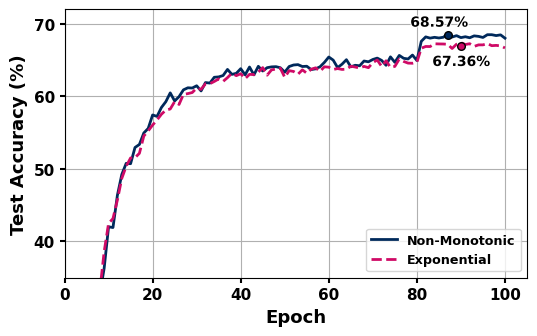

In [ ]:
########################################################################################################################
####-------| NOTE 13.  NON-MONOTONIC DECAY VS EXPONENTIAL DECAY| XXX --------------✅✅MAIN ✅✅--####################
########################################################################################################################



import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patheffects as path_effects
import os
from matplotlib.lines import Line2D  # ✅ Required for custom legend handles

def read_test_log(file_path):
    test_loss_history = []
    test_acc_history = []
    with open(file_path, 'r') as f:
        for line in f:
            if "Test Loss" in line and "Test Acc" in line:
                try:
                    loss = float(line.split("Test Loss:")[1].split("|")[0].strip())
                    acc = float(line.split("Test Acc:")[1].split("%")[0].strip())
                    test_loss_history.append(loss)
                    test_acc_history.append(acc)
                except:
                    continue
    return test_loss_history, test_acc_history

def plot_train_test_metrics(save_dir="./Results/Plots"):
    os.makedirs(save_dir, exist_ok=True)


    Linear_test_log_path  = f'./Results_NonMonotonicDecay/CIFAR100_Test_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'
    Exponential_test_log_path = f'./Results/CIFAR100_Test_{decay_mode}_B{bs}_LR{lr}_{net1}_{optimizer1}.txt'



    Linear_test_loss, Linear_test_acc = read_test_log(Linear_test_log_path)
    Exponential_test_loss, Exponential_test_acc = read_test_log(Exponential_test_log_path)

    num_epochs = min(len(Linear_test_loss), len(Exponential_test_loss))
    epochs = range(1, num_epochs + 1)

    COLOR_SCALE = ['#00295B', '#CF0A66']  # TargetPenalty, noTargetPenalty
    rcParams.update({
        "font.size": 11,
        "axes.titlesize": 11,
        "axes.labelsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "axes.labelweight": "bold",
        "xtick.color": "black",
        "ytick.color": "black",
    })

    # Custom settings
    custom_yticks_test_loss = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
    custom_yticks_test_acc = [10, 20, 30, 40, 50, 60, 70]
    custom_xticks = [0, 20, 40, 60, 80, 100]
    custom_yaxis_test_loss = [1.2, 4.2]
    custom_yaxis_test_acc = [35, 72]
    custom_xaxis = [0, 105]

    # Offsets
    y_offset_loss_tp = 0.2
    y_offset_loss_ntp = 0.07
    x_offset_loss_tp = 3.5
    x_offset_loss_ntp = 3.5

    y_offset_acc_tp = 1
    y_offset_acc_ntp = 3.2
    x_offset_acc_tp = 8.5
    x_offset_acc_ntp = 6.5

    # 🔷 Plot Test Loss
    fig1, ax1 = plt.subplots(figsize=(5.5, 3.5))
    ax1.plot(epochs, Linear_test_loss[:num_epochs], label="Non-Monotonic", color=COLOR_SCALE[0], linewidth=2)
    ax1.plot(epochs, Exponential_test_loss[:num_epochs], label="Exponential", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax1.set_xlabel("Epoch", fontweight='bold')
    ax1.set_ylabel("Test Loss", fontweight='bold')
    ax1.set_xticks(custom_xticks)
    ax1.set_yticks(custom_yticks_test_loss)
    ax1.set_xlim(custom_xaxis)
    ax1.set_ylim(custom_yaxis_test_loss)
    ax1.tick_params(axis='x', width=1.5)
    ax1.tick_params(axis='y', width=1.5)
    for label in ax1.get_xticklabels() + ax1.get_yticklabels():
        label.set_fontweight('bold')
    leg1 = ax1.legend(fontsize='small', loc="upper right")
    for text in leg1.get_texts():
        text.set_fontweight('bold')
    ax1.grid(True)

    ax1.plot(epochs[-1], Linear_test_loss[-1], marker='o', color=COLOR_SCALE[0], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_tp, Linear_test_loss[-1] - y_offset_loss_tp,
             f"{Linear_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax1.plot(epochs[-1], Exponential_test_loss[-1], marker='o', color=COLOR_SCALE[1], markersize=4)
    ax1.text(epochs[-1] - x_offset_loss_ntp, Exponential_test_loss[-1] + y_offset_loss_ntp,
             f"{Exponential_test_loss[-1]:.2f}", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_loss_non-monotonic_vs_linear.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    plt.close(fig1)

    # 🔶 Plot Test Accuracy — Marker at Best Accuracy
    best_epoch_tp = Linear_test_acc.index(max(Linear_test_acc)) + 1
    best_acc_tp = max(Linear_test_acc)
    best_epoch_ntp = Exponential_test_acc.index(max(Exponential_test_acc)) + 1
    best_acc_ntp = max(Exponential_test_acc)

    fig2, ax2 = plt.subplots(figsize=(5.5, 3.5))
    ax2.plot(epochs, Linear_test_acc[:num_epochs], label="Non-Monotonic", color=COLOR_SCALE[0], linewidth=2)
    ax2.plot(epochs, Exponential_test_acc[:num_epochs], label="Exponential", color=COLOR_SCALE[1], linestyle='--', linewidth=2)
    ax2.set_xlabel("Epoch", fontweight='bold')
    ax2.set_ylabel("Test Accuracy (%)", fontweight='bold')
    ax2.set_xticks(custom_xticks)
    ax2.set_yticks(custom_yticks_test_acc)
    ax2.set_xlim(custom_xaxis)
    ax2.set_ylim(custom_yaxis_test_acc)
    ax2.tick_params(axis='x', width=1.5)
    ax2.tick_params(axis='y', width=1.5)
    for label in ax2.get_xticklabels() + ax2.get_yticklabels():
        label.set_fontweight('bold')
    leg2 = ax2.legend(fontsize='small', loc="lower right")
    for text in leg2.get_texts():
        text.set_fontweight('bold')
    ax2.grid(True)

    # Markers for best accuracy
    ax2.plot(best_epoch_tp, best_acc_tp - 0.21, marker='o', color=COLOR_SCALE[0], markersize=5.5, markeredgecolor='black', markeredgewidth=1)
    ax2.text(best_epoch_tp - x_offset_acc_tp, best_acc_tp + y_offset_acc_tp,
             f"{best_acc_tp:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    ax2.plot(best_epoch_ntp, best_acc_ntp - 0.4, marker='o', color=COLOR_SCALE[1], markersize=5.5, markeredgecolor='black', markeredgewidth=1)
    ax2.text(best_epoch_ntp - x_offset_acc_ntp, best_acc_ntp - y_offset_acc_ntp,
             f"{best_acc_ntp:.2f}%", fontsize=10, color='black', fontweight='bold',
             path_effects=[path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "compare_test_accuracy_non-monotonic_vs_linear.svg"),
                format='svg', transparent=True, bbox_inches='tight')
    # plt.close(fig2)

    return f"✅ Annotated comparison plots with BEST accuracy markers saved to {save_dir}"

# 🔷 Call the function
plot_train_test_metrics()